# Preparations

In [ ]:
# make sure correct versions are installed/loaded!
# only relevant for clustering task (changes due to package upgrade might affect results of word clouds/clusters)
# uncomment to downgrade package to initial version during project analysis

# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.23.0

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

#Preprocessing
from scipy.stats import pearsonr, mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#Models
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#random state
randState = 0

#functions to chose data set and embeddings type:

# Choose data set
def chooseData(data = "BIG5"): #choose big5 or ipip ### dataset paths   
  folder = data.upper() + "/"
  data = data.lower() + "_"
  return folder, data

#Choose embeddings type
def chooseEmb(emb = "USE"): #choose big5 or ipip ### dataset paths   
  embeddings = "questions_embeddings_" + emb.upper() +  ".csv"
  save = "_" + emb.upper() +  ".csv"
  return embeddings, save

#choose prediction model
def predModel(nr=1,par=1):
  if nr == 1:
    model = RidgeClassifier(alpha=par, random_state=randState)
    modName = "RidgeClass"
  elif nr==2:  
    model = KNeighborsClassifier(n_neighbors=par)
    modName = "KNN"
  elif nr==3:
    model = SVC(C=par, random_state=randState)
    modName = "SVC"
  elif nr==4:  
    model = KNeighborsRegressor(n_neighbors=par)
    modName = "KnnReg"
  elif nr == 0:
    model = Ridge(alpha=par, random_state=randState)
    modName = "Ridge"
  print("running {}: ".format(modName))
  return model, modName 

#choose reversed or non reversed data
def getResponses(folder, data, R=1):
  if R == 1:
    res = "responses.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    savePath = "results/"+folder+"reversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)
  else:
    res = "responses_nonReversed.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    responses.columns.name = ""
    savePath = "results/"+folder+"nonReversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)

  return responses.astype(float), savePath, items, items_ids 

### Accuracy functions

In [2]:
def correlate(x,y): #pooled items performance
  corr_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  l1_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
    #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    y_pred_constr = x.iloc[:,constr_idx]   #get predictions
    y_test_constr = y.loc[y_pred_constr.index,questions[constr_idx]]    #get label
    y_pred_match = y_pred_constr.values.flatten('F') #convert to 1D array
    y_test_match = y_test_constr.values.flatten('F')
    y_pred_match = y_pred_match[~pd.isnull(y_test_match)] #drop nan values, important for IPIP
    y_test_match = y_test_match[~pd.isnull(y_test_match)]

    #calculate correlation
    corr = np.round(pearsonr(y_pred_match,y_test_match),2)
    corr_constr.iloc[:,nr] = corr[0]
    l1 = np.round(sum(np.abs(y_pred_match-y_test_match))/len(y_test_match),2)
    l1_constr.iloc[:,nr] = l1

  y_pred = x.values.flatten()
  y_test = y.loc[y_pred_constr.index,:].values.flatten()
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]

  corr_total, pval_total = np.round(pearsonr(y_pred,y_test),3)
  l1_total = np.round(sum(np.abs(y_pred-y_test))/len(y_test),3)
  return list(corr_constr.mean()), corr_total, pval_total, list(l1_constr.mean()), l1_total

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def corrUserBased(x,y):
  #calculate correlations and p value for every person, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[0],3),fill_value=0),index = x.index,columns=["Correlation","p-value","L1 Loss"])
  
  #new function, much faster, #NOT FOR IPIP, #adjust for p value of averages
  corrVals = x.corrwith(y, 1, method=lambda x, y: np.round(pearsonr(x, y), 6)).fillna(0)
  results.iloc[:,:2] = corrVals.values.tolist()
  results.iloc[:,2] = np.absolute(x - y).sum(1)/x.shape[1] 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0, #change to make n decimals!
  mean, ci_lower, ci_upper = mean_confidence_interval(results.Correlation)
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss'].mean(), ci_lower, ci_upper, t, results.shape[0]-1]

def corrAggregateScores(x,y): 
  #calculate correlations and p value for average user response:
  results = pd.DataFrame(np.full(shape=(constructs_list.shape[0],3),fill_value=0),index = constructs_list.tolist(), columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
      #labels and predictions for current construct 
      #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    A = x.iloc[:,constr_idx].mean(1)
    B = y.iloc[:,constr_idx].mean(1)
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[nr] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

def corrQuestionBased(x,y):
  #calculate correlations and p value for every question, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[1],3),fill_value=0), index = x.columns,columns=["Correlation","p-value","L1 Loss"])
  questions = x.columns

  #get correlation across participants for each question
  for i in range(x.shape[1]):
    A = x.loc[~pd.isnull(y.iloc[:,i]), x.columns[i]] #predicted responses for question "i" over all participants who answered said question
    B = y.loc[~pd.isnull(y.iloc[:,i]), y.columns[i]] #actual    responses for question "i" over all participants who answered said question
    corr,pval = pearsonr(A,B)
    L1 = sum(np.absolute(A - B))/A.shape[0]
    results.iloc[i] = np.array([corr,pval,L1]) 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss']] #add p value of average corr

# accuracy (percentage of correct classifications)
def accuracy_constr(x,y, constructs_list): #do we report the construct wise accuracy? we could otherwise use a heatmap!
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct accuracy
  questions = x.index

  y_pred = x.values.flatten()
  y_test = y.loc[questions,:].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total #list(metric_constr.mean()), metric_total

def accuracy_constr_comparison(x,y, constructs_total):
  constructs_total = constructs_total[x.index] #reorder according to x
  constructs_list = constructs_total.drop_duplicates().values.flatten()
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))), columns=constructs_list)  #Dataframe for construct accuracy
  y_test = y.loc[x.index,:].values.flatten() #re-order y according to x
  
  for constr in range(1, len(constructs_list)+1): # get performance by construct
    constr_idx = np.where(y_test == constr)[0]
    # get construct items/predictions
    y_pred_constr = x.values.flatten()[constr_idx]
    y_test_constr = y_test[constr_idx]
    # check for missing values
    y_test_constr = y_test_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_test_constr)]
    y_test_constr = y_test_constr[~pd.isnull(y_test_constr)]

    acc_constr = np.round(sum(y_pred_constr==y_test_constr)/len(y_test_constr),3)
    metric_constr.iloc[0, constr-1] = acc_constr

  y_pred = x.values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total, metric_constr #list(metric_constr.mean()), metric_total

def accuracy_keys(x,y, constructs_list):
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation

  y_pred = x.values.flatten()
  y_test = y.loc[x.index].values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total

def accuracy_keys_comparison(x,y, constructs_total):
  constructs_total = constructs_total[x.index] #reorder according to x
  constructs_list = constructs_total.drop_duplicates().values.flatten()
  metric_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))), columns=constructs_list)  #Dataframe for construct accuracy
  y_test = y[x.index].values.flatten() #re-order y according to x
  
  for constr in constructs_list: # get performance by construct
    constr_idx = np.where(constructs_total == constr)[0]
    # get construct items/predictions
    y_pred_constr = x.values.flatten()[constr_idx]
    y_test_constr = y_test[constr_idx]
    # check for missing values
    y_test_constr = y_test_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_pred_constr)]
    y_pred_constr = y_pred_constr[~pd.isnull(y_test_constr)]
    y_test_constr = y_test_constr[~pd.isnull(y_test_constr)]

    acc_constr = np.round(sum(y_pred_constr==y_test_constr)/len(y_test_constr),3)
    metric_constr.loc[0, constr] = acc_constr

  y_pred = x.values.flatten()
  y_test = y_test[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_pred)]
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]
  metric_total = np.round(sum(y_pred==y_test)/len(y_test),3)
  return metric_total, metric_constr

### Import functions: embeddings & response data

In [3]:
def getEmbeddings(folder, data, embeddings):
  #read in embeddings, order them like the response data and save in vector
  embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
  question_ids = responses.columns  #get IDs of questions answered

  # only get embeddings of questions having answers in matrix
  embeddings_df = embeddings_df.loc[question_ids,:]
  # save to vector 
  X = embeddings_df.values

  ################################ Preprocess input data::
  #Standardize for regression (wihtout PCA)
  X_stand = pd.DataFrame(StandardScaler().fit_transform(X),index=question_ids) #standardize embeddings
  #With PCA, for regression, 90% variance explained
  X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=question_ids) 

  return embeddings_df, X_stand, X_pca

def getData(m):
  
  question_ids = responses.columns
  data_q = X_pca_stand
  
  #choose parameter range
  if m==2 or m==4:  #KNN and KNN Regression
    list_par = [1,5,10,15,30,50] #parameter search
  elif m>=4:  #Random forest, extreme forest, gaussian
    list_par = [data_q.shape[1]] #parameter search
  else:  #Ridge, SVC
    list_par = [10**x for x in range(6)] #parameter search

  constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constrAssigned = constructs.loc[data_q.index,:] #only take constructs/encodings of items with embeddings
  constructs_list = constrAssigned.construct.drop_duplicates().values
  data_q = data_q.loc[constrAssigned.index,:] #only keep items that have an assigned construct

  return data_q, constructs_list, list_par, constrAssigned

Check Performance of given model + hyperparameter

In [112]:
# #model:
m   =   4             #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression
par = 5
corrMode = 2          #1: total, #2: userBased, #3: questionBased, #4: average construct scores (OCEAN Scores)
printAllCorrs = 0

#data:
R = 2               #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)
d = "IPIP"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"

#choose data set, embeddings, encoding
folder, data = chooseData(d)                                      # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)                                   # USE, BERT, SENTENCEBERT
responses, savePath, items,_ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed

folder = "results/"
models = ["LIWC", "WORD2VEC", "SENTENCEBERT"]
model_outputs = ["Ridge_10_LIWC_responses.csv", "SVC_10_WORD2VEC_responses.csv", "KnnReg_5_SENTENCEBERT_responses.csv"]
model_output = [x for x in model_outputs if e.upper() in x][0]
path = folder + d.upper() + "/nonReversed/" + model_output

print("Dataset: " + d.upper())
print("Model: " + e.upper())
x = pd.read_csv(path, index_col=0, dtype={'INDEX':str})
x.index = x.index.map(str)
y = responses.copy()
results, resultsMean = corrUserBased(x, y)

Dataset: IPIP
Model: SENTENCEBERT


In [113]:
resultsMean

[0.3666915155279503,
 1.2125096344080026e-91,
 0.12544736011770388,
 0.35032252506923806,
 0.3830605059866626,
 44.240947410852165,
 160]

# Predictions

## Predict responses

### Hyperparameter search

In [ ]:
for l in ['sentencebert', "word2vec", "LIWC"]: #go through the three embeddings, HSQ and HEXACO don't have SBERT embeddings
  for k in range(5):                       #calculate for each prediction model
    for j in range(1,3):                   #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)

      # #model:
      m = k           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
      #data:
      R = j           #1: reversed-coded, #2: nonReversed-coded

      ############################ choose output here ##############################
      d = "big5"       #data set   # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      e = l
      corrMode = 2      #1: pooled items performance,  #2: user averaged, #3: question averaged #4: construct scores (e.g. OCEAN Scores)
      printAllCorrs = 0 #1: yes,  #0: no
      #####################################################################################

      #choose data set, embeddings, encoding
      folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
      embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
      responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
      X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

      #get embeddings name:
      embName = embeddings.split("_")[2].split(".")[0]

      # import required data and labels
      data_q, constructs_list, list_par, constrAssigned = getData(m)

      ############################## 10-Fold cross validation:
      #Split dataframe 10 fold
      kf = KFold(n_splits=10, random_state=randState, shuffle=True)
      questions = list(kf.split(data_q))

      #get ids
      question_ids = responses.columns  #get IDs of questions answered
      user_ids = responses.index        #get IDs of users

      #initialise parameters:
      old_corr = -100
      acc_old = -1
      ##################################### predictions #####################################

      for par in list_par:

        model, modelName = predModel(m,par) 
        #Dataframes to store all predictions
        total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
        total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

        for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
          #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
          
          #train/test index and embeddings for current fold
          qid_train = q_fold[0]
          qid_test = q_fold[1]
          q_test = data_q.iloc[qid_test]

          # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
          for user,y in enumerate(responses.values):
            
            q_train = data_q.iloc[qid_train]
            #get responses for ith user on the training questions
            y_train = y[qid_train]
            q_train = q_train.loc[~pd.isnull(y_train),:]
            y_train = y_train[~pd.isnull(y_train)].astype('int')

            if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (because SVC does not work with only one class)
              y_pred = np.repeat(y_train[0],q_test.shape[0])
            else: 
              y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

            y_pred[y_pred < 1] = 1
            y_pred[y_pred > 5] = 5

            #Dumb predictor uses mode of training data to predict the fold
            if data[:-1] == "npi": #for classification of the NPI data set
              y_dumb = np.repeat(mode(y)[0],q_test.shape[0])
            else: #all others
              y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

            #save predictions in in dataframe
            total_preds.iloc[user, qid_test] = y_pred
            total_dumb.iloc[user, qid_test] = y_dumb

        #Model metrics:
        print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...

        # #calculate model metrics:
        if corrMode == 1 or printAllCorrs == 1:
          corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
          #DUMB:
          corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_DUMB, l1_dumb = correlate(total_dumb, responses)

          model_tag = modelName + " (N=" + str(par) + ")"
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("pooled:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 2 or printAllCorrs == 1:
          results, resultsMean = corrUserBased(total_preds, responses)
          corr, pval, l1, ci_lower, ci_upper, t, dof = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb, ci_lower_dumb, ci_upper_dumb, t_dumb, dof_dumb = resultsMean_dumb
        
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("user based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 3 or printAllCorrs == 1:
          results, resultsMean = corrQuestionBased(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("question based:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if corrMode == 4 or printAllCorrs == 1:
          results, resultsMean = corrAggregateScores(total_preds, responses)
          corr, pval, l1 = resultsMean

          model_tag = modelName + " (N=" + str(par) + ")"
          #DUMB:
          results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
          corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
          #additional information when all metrics are print out together
          if printAllCorrs == 1:
            print("aggregated:")
            print([round(corr,3), round(l1,3), round(pval,3)])

        if printAllCorrs != 1:
          print([round(corr,3), round(l1,3), round(pval,3)])
          print("\n")
          if corrMode == 1:
            print("Correlation across all folds, by construct: \n", corr_constr)
            # print("L1-Loss across all folds, by construct: \n", l1_constr)
            print("\n")
            pass
            
        total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv") #save predictions -> to calculate and predict performance for plots

        #stop search after maximum
        new_corr = corr
        if new_corr < old_corr:
          break
        else:
          old_corr = new_corr 

### Single predictions

In [ ]:
# #model:
m   =   4             #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression
par = 5
corrMode = 2          #1: total, #2: userBased, #3: questionBased, #4: average construct scores (OCEAN Scores)
printAllCorrs = 0

#data:
R = 2               #1: reversed, #2: nonReversed, RiASEC has only (j=2), IPIP with all items has only (j=2)
d = "16pf"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"

#choose data set, embeddings, encoding
folder, data = chooseData(d)                                      # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)                                   # USE, BERT, SENTENCEBERT
responses, savePath, items,_ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf = KFold(n_splits=10, random_state=randState, shuffle=True)
questions = list(kf.split(data_q))

#get ids
question_ids = responses.columns  #get IDs of questions answered
user_ids = responses.index        #get IDs of users

#################################### predictions #####################################

model, modelName = predModel(m,par) 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)
total_dumb = pd.DataFrame(np.full(responses.shape, np.nan), columns=question_ids, index=user_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions,range(len(questions))): #go through the question folds
  print("Fold {}:".format(str(fold_nr + 1))) #status/progress
  
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_test = data_q.iloc[qid_test]

  # (train:) for each userfold go through all questions of the question fold and concatenate question embedding to all users
  for user,y in enumerate(responses.values):
    
    q_train = data_q.iloc[qid_train]
    #get responses for ith user on the training questions
    y_train = y[qid_train]
    q_train = q_train.loc[~pd.isnull(y_train),:]
    y_train = y_train[~pd.isnull(y_train)].astype('int')

    if (m==3) & (len(set(y_train)) == 1): #if only one type of response in training fold, use value for prediction (SVC does not work with only one class)
      y_pred = np.repeat(y_train[0],q_test.shape[0])
    else: 
      y_pred = np.round(model.fit(q_train,y_train).predict(q_test),0)

    y_pred[y_pred < 1] = 1
    y_pred[y_pred > 5] = 5
    y_dumb = np.repeat(np.round(np.mean(y_train),0),q_test.shape[0]) 

    #save predictions in in dataframe
    total_preds.iloc[user, qid_test] = y_pred
    total_dumb.iloc[user, qid_test] = y_dumb

# #calculate model metrics:
if corrMode == 1 or printAllCorrs == 1:
  corr_constr, corr, pval, l1_constr, l1 = correlate(total_preds, responses)
  #DUMB:
  corr_constr_DUMB, corr_dumb, pval_dumb, l1_constr_dumb, l1_dumb = correlate(total_dumb, responses)
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("pooled:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 2 or printAllCorrs == 1:
  results, resultsMean = corrUserBased(total_preds, responses)
  corr, pval, l1, ci_lower, ci_upper, t, dof = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb, ci_lower_dumb, ci_upper_dumb, t_dumb, dof_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("user based:")
    print([round(corr,3), round(ci_lower,3), round(ci_upper,3), round(l1,3), round(pval,3)])

if corrMode == 3 or printAllCorrs == 1:
  results, resultsMean = corrQuestionBased(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrQuestionBased(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("question based:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if corrMode == 4 or printAllCorrs == 1:
  results, resultsMean = corrAggregateScores(total_preds, responses)
  corr, pval, l1 = resultsMean
  #DUMB:
  results_dumb, resultsMean_dumb = corrAggregateScores(total_dumb, responses)
  corr_dumb, pval_dumb, l1_dumb = resultsMean_dumb
  #additional information when all metrics are print out together
  if printAllCorrs == 1:
    print("aggregated:")
    print([round(corr,3), round(l1,3), round(pval,3)])

if printAllCorrs != 1:
  print([round(corr,3), round(ci_lower,3), round(ci_upper,3), round(l1,3), round(pval,3)])
  print("\n")
  if corrMode == 1:
    print("Correlation across all folds, by construct: \n", corr_constr)
    print("L1-Loss across all folds, by construct: \n", l1_constr)
    print("\n")

# total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv")
# total_dumb.to_csv(savePath + 'baseline' + "_responses.csv")

## Predict constructs

### Hyperparameter search

In [ ]:
for  l in ['sentencebert', "word2vec", "liwc"]: #go through the three embeddings
  for k in range(1,4):                          #calculate for each prediction model

    ################################################ model:
    m = k                 #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
    ################################################ choose data:
    d = "hsq"             #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
    e =  l                #embeddings type: USE, BERT, SENTENCEBERT

    #import data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items, _ = getResponses(folder, data, 2) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    # #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    y_constr = constrAssigned.construct.values #get construct values
    #dicts to convert number to constructs and vice versa
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

    ##################################### predictions #####################################
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100
    kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10-Fold cross validation
    questions_constr = list(kf_constr.split(data_q))

    for par in list_par:
      model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        q_train = data_q.iloc[qid_train]
        q_test = data_q.iloc[qid_test]

        y_train = y.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(y)[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_constr(total_preds, y, constructs_list) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_constr(total_dumb, y, constructs_list)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      #save results
      total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")

      #stop search criterium (e.g., when accuracy reduces, potentially use better parameter search)
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
################################################ model:
m = 1                   #0: KNN Reg, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 1000
################################################ choose data:
d = "ipip2"             #data set, BIG5, IPIP2, RIASEC, 16PF, HSQ
e = "liwc"              #embeddings type: USE, BERT, WORD2VEC, SENTENCEBERT

#import data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items, _ = getResponses(folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

# #get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]
# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)

y_constr = constrAssigned.construct.values #get construct values
#dicts to convert number to constructs and vice versa
constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

##################################### predictions #####################################

question_ids = data_q.index  #get IDs of questions answered
kf_constr = KFold(n_splits=10, random_state=randState, shuffle=True) #10 Fold cross validation
questions_constr = list(kf_constr.split(data_q))

model, modelName = predModel(m,par)  #model = LogisticRegression(C = par), 
#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["constructs"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  q_train = data_q.iloc[qid_train]
  q_test = data_q.iloc[qid_test]

  y_train = y.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(stats.mode(y.constructs)[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_constr(total_preds, y, constructs_list) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_constr(total_dumb, y, constructs_list)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs.csv")
total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_constructs_dumb.csv")

## Predict keys

### Hyperparameter search

In [ ]:
for  l in ['sentencebert', "word2vec", "liwc"]:     #go through the three embeddings
  for k in range(1,4):                              #calculate for each prediction model
    m = k                                           #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)

    #data:
    d = "hsq"         # BIG5, 16PF, HSQ 
    e = l             # Embeddings: USE, BERT, SENTENCEBERT

    #choose data set, embeddings, encoding
    folder, data = chooseData(d) 
    embeddings, save = chooseEmb(e) 
    responses, savePath, items, _ = getResponses(folder, data, 1) #1: Reversed, #2: nonReversed
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m)
    keys = constrAssigned.encoding.replace([-1,1],[1,0])

    ############################## 10-Fold cross validation:
    #Split dataframe 10 fold
    kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
    questions_constr = list(kf_constr.split(data_q))
    question_ids = data_q.index  #get IDs of questions answered

    #initialise parameters:
    old_acc = -100

    ##################################### predictions #####################################

    for par in list_par:
      model, modelName = predModel(m,par)

      #Dataframes to store all predictions
      total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
      total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

      for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds
        #print("Fold {}:".format(str(fold_nr + 1))) #status/progress
      
        #train/test index and embeddings for current fold
        qid_train = q_fold[0]
        qid_test = q_fold[1]
        idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
        qid_train_constr = qid_train[idx]
        q_train = data_q.iloc[qid_train_constr]
        q_test = data_q.iloc[qid_test]
        y_train = keys.loc[q_train.index].values.flatten()
        y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
        #Dumb predictor uses mode of training data to predict the fold
        y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

        #save predictions in in dataframe
        total_preds.iloc[qid_test,0] = y_pred
        total_dumb.iloc[qid_test,0] = y_dumb

      #calculate model metrics:
      acc_total = accuracy_keys(total_preds, keys, constructs_list) #correct classifications percentage
      #DUMB metrics:
      acc_dumb_total = accuracy_keys(total_dumb, keys, constructs_list)  #correct dumb classifications percentage

      print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
      print("Correct classifications across all folds: ", acc_total)
      print("Correct DUMB classifications across all folds: ", acc_dumb_total)
      print("\n")

      # save results
      total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")

      #stop search after accuracy reduces
      new_acc = acc_total
      if new_acc < old_acc:
        break
      else:
        old_acc = new_acc

### Single prediction

In [ ]:
m = 1             #1: RidgeClass, #2: KNN, #3: Kernel SVM (RBF)
par = 10

#data:
d = "hsq"         # BIG5, 16PF, HSQ
e = 'liwc'        #Embeddings: USE, BERT, SENTENCEBERT

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb(e) 
responses, savePath, items, _ = getResponses(folder, data, 2) #1: Reversed, #2: nonReversed
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels
data_q, constructs_list, list_par, constrAssigned = getData(m)
keys = constrAssigned.encoding.replace([-1,1],[1,0])

############################## 10-Fold cross validation:
#Split dataframe 10 fold
kf_constr = KFold(n_splits=responses.shape[1], random_state=randState, shuffle=True) #leave one out cross validation
questions_constr = list(kf_constr.split(data_q))
question_ids = data_q.index  #get IDs of questions answered

#initialise parameters:
old_acc = -100

##################################### predictions #####################################

model, modelName = predModel(m,par)

#Dataframes to store all predictions
total_preds = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)
total_dumb = pd.DataFrame(np.full((data_q.shape[0],1), np.nan), columns=["encoding"], index=question_ids)     #dumb predictor individual level

for q_fold, fold_nr in zip(questions_constr,range(len(questions_constr))): #go through the question folds

  #train/test index and embeddings for current fold
  qid_train = q_fold[0]
  qid_test = q_fold[1]
  idx = np.where(constrAssigned.construct[qid_test].values == constrAssigned.construct[qid_train].values)[0]
  qid_train_constr = qid_train[idx]
  q_train = data_q.iloc[qid_train_constr]
  q_test = data_q.iloc[qid_test]

  y_train = keys.loc[q_train.index].values.flatten()
  y_pred  = np.round(model.fit(q_train, y_train).predict(q_test),0)
  #Dumb predictor uses mode of training data to predict the fold
  y_dumb = np.repeat(mode(keys.values.flatten())[0],q_test.shape[0])

  #save predictions in in dataframe
  total_preds.iloc[qid_test,0] = y_pred
  total_dumb.iloc[qid_test,0] = y_dumb

#calculate model metrics:
acc_total = accuracy_keys(total_preds, keys, constructs_list) #correct classifications percentage
#DUMB metrics:
acc_dumb_total = accuracy_keys(total_dumb, keys, constructs_list)  #correct dumb classifications percentage

print("MODEL: " + modelName + " (par = " + str(par) + ") " + embName + ":\n") #hand over string with specs...
print("Correct classifications across all folds: ", acc_total)
print("Correct DUMB classifications across all folds: ", acc_dumb_total)
print("\n")

# save results
total_preds.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased.csv")
total_dumb.to_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_encodings_constrBased_dumb.csv")

# Visualise Model performance

load prediction results and corresponding observations

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

### Bar plots of response prediction performance

#### Calculate participant averaged performance across data sets

Creates a dataframe with the performance in the response prediction task of each embedding type for all data sets

In [ ]:
# creates a dataframe with the best performing models for each embeddings method

# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'
model, modelName = predModel(m,par) 

datasets = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])
sig_data = []

#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #add LIWC
  #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items, _ = getResponses(folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline' + "_responses.csv", index_col=0)
  responses.index = total_preds.index
  #get userbased correlations
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results.loc[(results.Correlation > 0) & (results["p-value"]<0.05),:].shape[0]/results.shape[0]
  sig_data.append([i, "SBERT", sig_count])

  #combine correlations of all datasets in one frame
  performance = performance.append(results)

  #add word2vec Baseline
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
  #get userbased correlations
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])

  # get percentage of significant positive correlations
  sig_count = results3.loc[(results3.Correlation > 0) & (results3["p-value"]<0.05),:].shape[0]/results3.shape[0]
  sig_data.append([i, "WORD2VEC", sig_count])

  #combine correlations of all datasets in one frame
  performance = performance.append(results3)

  #get LIWC baseline data
  #choose best model for LIWC
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
  #get userbased correlations
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results2.loc[(results2.Correlation > 0) & (results2["p-value"]<0.05),:].shape[0]/results2.shape[0]
  sig_data.append([i, "LIWC", sig_count])

  #combine correlations of all datasets in one frame
  performance = performance.append(results2)
  performance = performance.append(results_dumb)

# save results
performance = performance.reset_index(drop=True)
performance.to_csv("plot_data/performances.csv")

#### Performance plots (from pre-saved data)

Creates plots from data created in code above

In [ ]:
performance = pd.read_csv("plot_data/performances.csv", index_col=0)

# reshape data frame to show performance for each embedding type
cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

# rename for better display in plots
plot_data['Model'] = ["Word2Vec" if item=="WORD2VEC" else item for item in plot_data['Model']]
plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

#create plots
fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP']
dataset_names = ['NEO-PR-I', '16PF', 'HSQ', 'RIASEC', 'IPIP']

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(5):

    #Add the performance plots:
    data = plot_data[(plot_data.Dataset == order[i]) & (plot_data.Model != "Average\nResponse")]
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=data, ci=95, palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    plt.savefig("plot_data/" + fig_name, bbox_inches='tight')

    #Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

#     # change to local directory
    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    plt.savefig("plot_data/" + fig_name, bbox_inches='tight')
#     files.download(fig_name)

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()

Show percentage of significant positive correlations for each embedding type and data sets

In [ ]:
significance_df = pd.read_csv("plot_data/sig_counts.csv")
significance_df

Look up performances for specific data sets and embedding types

In [ ]:
dataset = "big5"
embedding_type = "word2vec"
performance = pd.read_csv("plot_data/performances.csv", index_col=0)
performance.loc[(performance.Dataset == dataset.upper())  & (performance.Model == embedding_type.upper()), ["Correlation", "p-value", "L1 Loss"]].mean() #look up specific performances (baseline or model)

### Bar plot human vs computer performance

#### Functions

In [5]:
""" Functions """
from numpy import nanmean

# calculate confidence interval around correlation
def pearsonr_ci(r, p, n, alpha=0.05):
    r_z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# calculate confidence interval around mean
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# calculate correlations for model predictions and human raters
def regCorr(target_list, n_steps, model_data): #also calculate model data in the same way
    responses = pd.read_csv('embeddings/' + "BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #load actual participant responses

    corrs_list = []
    pvals_list = []
    comp_corrs_list = []
    comp_pvals_list = []
    for i, (df, df_name) in enumerate(target_list):
        y = responses.loc[:,df.columns[1]].values
        y = y[df.index]
        corrs = []
        pvals = []
        for col in df.iloc[:,2:]:
            full_col = df.loc[:,col]
            for nr_p in range(int(df.shape[0]/n_steps)):
                human_preds = full_col[nr_p*n_steps:(nr_p+1)*n_steps] #there are 10 predictions per person
                y_curr = y[nr_p*10:nr_p*10+10]
                y_curr = y_curr[~np.isnan(human_preds)] #remove nan
                x_curr = human_preds[~np.isnan(human_preds)]
                
                try: #4 participants with not enough ratings!
                    cor, p = pearsonr(y_curr, x_curr)
                except:
                    cor = np.nan
                    p = np.nan
                corrs.append(cor)
                pvals.append(p)
              
        corrs_list.append(corrs)
        pvals_list.append(pvals)            
        
        #computational model's performance
        predictions = model_data.loc[model_data.index[i], model_data.columns[df.index]].values.reshape((10,10))
        actual_values = y.reshape((10,10)) #also check order -> import fold item order!
        comp_corrs = []
        comp_pvals = []
        for i in range(predictions.shape[0]):
            x_curr = predictions[i]
            y_curr = actual_values[i]
            
            try: #4 participants with not enough ratings!
                cor, p = pearsonr(y_curr, x_curr)
            except:
                cor = np.nan
                p = np.nan
            comp_corrs.append(cor)
            comp_pvals.append(p)
            
        comp_corrs_list.append(comp_corrs)
        comp_pvals_list.append(comp_pvals)

    return corrs_list, pvals_list, comp_corrs_list, comp_pvals_list

""" Data Imports """
import scipy.stats

xslx = pd.ExcelFile("results/human_eval_unreversed.xlsx")
target_25 = pd.read_excel(xslx, "25%", index_col=0)
target_50 = pd.read_excel(xslx, "50%", index_col=0)
target_75 = pd.read_excel(xslx, "75%", index_col=0)
target_list = [(target_25, "25%"), (target_50, "50%"), (target_75, "75%")]

# model_performance = pd.read_csv("results/" + "best_model_results_userBased.csv", index_col=0)
predictions = pd.read_csv("results/BIG5/nonReversed/" + "KnnReg_5_SENTENCEBERT_responses.csv", index_col=0)
predictions_targets = predictions.loc[[df[0].columns[1] for df in target_list],:]

#### Plots

##### Plot 1: <br>
Computational model's and human raters' performance as correlation of test fold predictions and test fold observations. <br>
Report mean fold performance and 95% CI.

Create dataframe for plotting

In [6]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# Confidence intervals
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

#create dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

F:\Programmes\Anaconda\envs\eager\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


One-sample t-test against zero mean for average correlations (humans vs model)

In [7]:
i = 0 #0-25th percentile, 1-50th percentile, 2-75th percentile

#humans
ttest_h = stats.ttest_1samp(cor_h[i], 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)

#model
ttest_c = stats.ttest_1samp(cor_comp[i], 0, nan_policy="omit")
t_c = round(ttest_c[0], 3)
p_c = round(ttest_c[1], 4)

print("Human raters:")
print(corrs_means[i])
print(t_h)
print(p_h)

print("\nModel:")
print(corrs_comps[i])
print(t_c)
print(p_c)

Human raters:
0.386
17.8
0.0

Model:
0.379
4.072
0.0028


In [11]:
#humans
h = [x for s in cor_h for x in s]
ttest_h = stats.ttest_1samp(h, 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)

#model
c = [x for s in cor_comp for x in s]
ttest_c = stats.ttest_1samp(c, 0, nan_policy="omit")
t_c = round(ttest_c[0], 3)
p_c = round(ttest_c[1], 4)

print("Human raters:")
print(nanmean(h))
print(t_h)
print(p_h)

print("\nModel:")
print(nanmean(c))
print(t_c)
print(p_c)

Human raters:
0.4650420255302473
36.092
0.0

Model:
0.48166838624547
9.573
0.0


Test the human rater performance for the outlier condition (50th percentile target, 10th fold)

In [ ]:
i = 1 #Target
j = 9 #Fold

folds_h = np.array([cor_h[i][j:j+n] for j in range(0,len(cor_h[i]), 10)])
humans = pd.DataFrame(folds_h_loop, columns = ["Fold: " + str(i) for i in range(1,11)])

# humans = nanmean(folds_h, 0)

#humans
ttest_h = stats.ttest_1samp(humans[humans.columns[j]], 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)
print(t_h)
print(p_h)
print(round(humans.mean()[9], 3))

In [ ]:
print(cor_comp[i][9])
print(p_comp[i][9])

Create plots

In [ ]:
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations
corrs_means = [np.nanmean(x).round(3) for x in cor_h] #humans
pvals_means = [np.nanmean(x).round(3) for x in p_h]
corrs_comps = [np.nanmean(x).round(3) for x in cor_comp] #computational model
pvals_comps = [np.nanmean(x).round(3) for x in p_comp]

# CI
ci_corr_model = [mean_confidence_interval(x) for x in cor_comp] #comp model
yerr_model = [(x[2]-x[1])/2 for x in ci_corr_model]
ci_corr_human = [mean_confidence_interval(x) for x in cor_h] #humans
yerr_human = [(x[2]-x[1])/2 for x in ci_corr_human]

#plot dataframe
performance = pd.DataFrame(np.array([["25th percentile", 'Computational Model', corrs_comps[0], yerr_model[0]],
                                      ["50th percentile",'Computational Model', corrs_comps[1], yerr_model[1]],
                                      ["75th percentile", 'Computational Model', corrs_comps[2], yerr_model[2]],
                                          ["25th percentile", 'Human Raters', corrs_means[0], yerr_human[0]],
                                          ["50th percentile",'Human Raters',  corrs_means[1], yerr_human[1]],
                                          ["75th percentile", 'Human Raters',  corrs_means[2], yerr_human[2]]]), columns=["target", "model", "correlation", "yerr"])
performance.iloc[:, -2:] = performance.iloc[:, -2:].astype(float)
labels = performance.target.drop_duplicates().tolist() #bar labels
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
comp = performance[performance.model == 'Computational Model'] #comp model bars
hum = performance[performance.model == 'Human Raters'] #human bars
rects1 = ax.bar(x - width/2, comp.correlation.values, width, label='Computational Model', yerr = comp.yerr.values, capsize=0.2, color = 'cornflowerblue') #bar plots
plt.errorbar(x - width/2, comp.correlation.values,  yerr=comp.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
rects2 = ax.bar(x + width/2, hum.correlation.values, width, label='Human Raters', yerr = hum.yerr.values, capsize=0.2, color = 'limegreen')
plt.errorbar(x + width/2, hum.correlation.values,  yerr=hum.yerr.values, fmt=' ', markersize=8, capsize=10, capthick=2, ecolor='k')
ax.grid(False, axis='x')

for p in ax.patches:
    ax.annotate("  %.2f" % round(p.get_height(),2), xy=(p.get_x(), p.get_height()),
            xytext=(30, -1), textcoords='offset points', ha="left", va="bottom", fontweight='bold',fontsize=14)
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Target Participant', fontweight = "bold", fontsize = 16)
# ax.set_title('Comparison of computational model\'s vs human raters\' prediction performance', fontweight = "bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 14)
plt.yticks(fontsize = 14)
ax.legend(loc="lower right", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold', 'size':12})

plt.savefig("plot_data/fig3a.pdf")

Show performance estimates (average correlations) and confidence intervals for human/model predictions for each target

In [ ]:
targets_labels = ["25th percentile", "50th percentile", "75th percentile"]
for i in range(3):
  print(str(targets_labels[i]) + ": ")
  dropna_comp = [x for x in cor_comp[i] if str(x) != 'nan']
  dropna_h = [x for x in cor_h[i] if str(x) != 'nan']
  ci_human = [round(x, 3) for x in ci_corr_human[i]]
  ci_model = [round(x, 3) for x in ci_corr_model[i]]
  
  #print values for human raters and predictive model
  print('\nHuman judges:')
  print("CI (mean, lower-CI, upper-CI)")
  print(ci_human)
  print("p-value")
  print(str(round(stats.ttest_1samp(dropna_h,0)[1],5)))

  print('\nBest Model:')
  print("CI (mean, lower-CI, upper-CI)")
  print(ci_model)
  print("p-value")
  print(str(round(stats.ttest_1samp(dropna_comp,0)[1],5)))

  print("\n")

Get confidence interval and p-value for performance (average correlation) across all human/model predictions 

In [ ]:
dropna_comp = [x for s in cor_comp for x in s if str(x) != 'nan']
dropna_h = [x for s in cor_h for x in s if str(x) != 'nan']
ci_human = [round(x,3) for x in mean_confidence_interval([x for s in cor_h for x in s])]
ci_model = [round(x,3) for x in mean_confidence_interval([x for s in cor_comp for x in s])]

print("Human predictions (Mean, lower-CI, upper-CI)")
print(ci_human) # mean, lower CI, upper CI
print(str(round(stats.ttest_1samp(dropna_comp,0)[1],5)))
print("\n")
print("Model predictions (Mean, lower-CI, upper-CI)")
print(ci_model) # mean, lower CI, upper CI
print(str(round(stats.ttest_1samp(dropna_comp,0)[1],5)))

Compare performance of humans vs model (for statistical significance)

In [ ]:
humans = np.array([x for s in cor_h for x in s if str(x) != 'nan'])
model = np.array([x for s in cor_comp for x in s if str(x) != 'nan'])

tstat = stats.ttest_ind(humans, model, equal_var=False)

print("T: " + str(round(tstat[0], 3)))
print("p-value: " + str(round(tstat[1], 3)))

In [ ]:
# Get degree of freedom (same t_test function as above!)
def welch_t_test(mu1, s1, N1, mu2, s2, N2):
  # Construct arrays to make calculations more succint.
  N_i = np.array([N1, N2])
  dof_i = N_i - 1
  v_i = np.array([s1, s2]) ** 2
  # Calculate t-stat, degrees of freedom, use scipy to find p-value.
  t = (mu1 - mu2) / np.sqrt(np.sum(v_i / N_i))
  dof = (np.sum(v_i / N_i) ** 2) / np.sum((v_i ** 2) / ((N_i ** 2) * dof_i))
  p = stats.distributions.t.sf(np.abs(t), dof) * 2
  return t, p, dof

welch_stat = welch_t_test(np.mean(humans), np.std(humans, ddof=1), humans.size,
                           np.mean(model), np.std(model, ddof=1), model.size)

print("DOF: " + str(round(welch_stat[2], 3)))
print("T: " + str(round(welch_stat[0], 3)))
print("p-value: " + str(round(welch_stat[1], 3)))

##### Plot 2: Scatter plot

In [ ]:
#plot dataframe
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations

rows = []
targets=["25th Percentile", "50th Percentile", "75th Percentile"]
for i in range(3):
  humans = nanmean(np.array([cor_h[i][j:j+n] for j in range(0,len(cor_h[i]), 10)]),0) #reshape to folds
#   humans = nanmean(np.reshape(cor_h[i], (10,21)), 1)
  model = cor_comp[i]
  target = [targets[i]]*10
  rows.extend(list(zip(folds_humans, model, target)))
df = pd.DataFrame(rows, columns=["humans", "model", "target"])
color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}
                                          
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(6, 6), dpi = 150) #figure specs
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime','blue'], alpha=0.7)
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','lime',"steelblue"], alpha=1.0)
# sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, palette = ['red','limegreen','deepskyblue'], alpha=0.7)
    
# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
# ax.set_title('Human vs computational performances for each target participant', fontweight = "bold")
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13})
ax.plot((-0.2, 1),(-0.2, 1), ls='--')
plt.xlim(-0.3,1)
plt.ylim(-0.3,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#change to save in local directory
plt.savefig("plot_data/fig3b.svg")

### Bar plot for construct/key prediction performance

#### Function for context plot creation

In [12]:
#create functions:
#calculate accuracy for the construct or direction prediction tasks
def contextAccuracy(context="construct", i='Big5'):
  performance = pd.DataFrame(columns=["Dataset", "Target", "Model", "Accuracy"])
  #get the output data and path for respective context
  if context=="keys":
    m = 1
    par = 10  
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    ending = "_encodings_constrBased"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = "results/" + folder + "nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv("embeddings/" + folder + data + embeddings,index_col=0)
    constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    y = constrAssigned.encoding.replace([-1,1],[1,0])
    func = accuracy_keys
  elif context=="construct":
    ending = "_constructs"
    m = 1
    par = 1000 
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = "results/" + folder + "nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    # print(constructs_list)
    #dicts to convert number to constructs and vice versa
    y_constr = constrAssigned.construct
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= y_constr.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)    
    func = accuracy_constr
  
  # get predicted responses of chosen model:
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + ".csv", index_col=0)
  total_preds.index = total_preds.index.map(str)
  total_preds = total_preds.astype(float)

  total_preds2 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'LIWC' + ending + ".csv", index_col=0)
  total_preds2.index = total_preds2.index.map(str)
  total_preds2 = total_preds2.astype(float)

  total_preds3 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'WORD2VEC' + ending + ".csv", index_col=0)
  total_preds3.index = total_preds3.index.map(str)
  total_preds3 = total_preds3.astype(float)

  total_dumb = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + '_dumb' + ".csv", index_col=0)
  total_dumb.index = total_dumb.index.map(str)
  total_dumb = total_dumb.astype(float)

  #get performance metrict
  results  = func(total_preds, y, constructs_list)
  results2 = func(total_preds2, y, constructs_list)
  results3 = func(total_preds3, y, constructs_list)
  results_dumb = func(total_dumb, y, constructs_list)

  #combine in single frame
  performance.loc[len(performance)] = [i, context, "Best Model",  results]
  performance.loc[len(performance)] = [i, context, "LIWC",        results2]
  performance.loc[len(performance)] = [i, context, "WORD2VEC",    results3]
  performance.loc[len(performance)] = [i, context, "Baseline",    results_dumb]
  #combine correlations of all datasets in one frame
  return performance

#get performance for construct/direction prediction task by construct (prediction accuracy on all item belonging to that construct)
def contextAccuracy_constr(context="construct", i='Big5'):
  performance = pd.DataFrame(columns=["Dataset", "Target", "Model", "Construct", "Accuracy"])
  #get the output data and path for respective context
  if context=="keys":
    m = 1
    par = 10  
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    ending = "_encodings_constrBased"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = "results/" + folder + "nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    y = constrAssigned.encoding.replace([-1,1],[1,0])
    func = accuracy_keys_comparison
  elif context=="construct":
    ending = "_constructs"
    m = 1
    par = 1000 
    model, modelName = predModel(m,par) 
    e = "sentencebert"
    #load path and necessary variables:
    folder, data = chooseData(i)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
    embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
    savePath = "results/" + folder + "nonReversed/"
    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]
    # import required data and labels:
    embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
    constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
    constrAssigned = constructs.loc[embeddings_df.index,:] #only take constructs/encodings of items with embeddings
    constrAssigned = constrAssigned[constrAssigned.construct != 'not assigned']
    constructs_list = constrAssigned.construct.drop_duplicates().values
    # print(constructs_list)
    #dicts to convert number to constructs and vice versa
    constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
    y = pd.DataFrame(np.asarray((list(map(constrNr.get, constrAssigned.construct)))), index= constrAssigned.construct.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)    
    func = accuracy_constr_comparison
  
  # get predicted responses of chosen model:
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + ".csv", index_col=0)
  total_preds.index = total_preds.index.map(str)
  total_preds = total_preds.astype(float)

  total_preds2 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'LIWC' + ending + ".csv", index_col=0)
  total_preds2.index = total_preds2.index.map(str)
  total_preds2 = total_preds2.astype(float)

  total_preds3 = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + 'WORD2VEC' + ending + ".csv", index_col=0)
  total_preds3.index = total_preds3.index.map(str)
  total_preds3 = total_preds3.astype(float)

  total_dumb = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + ending + '_dumb' + ".csv", index_col=0)
  total_dumb.index = total_dumb.index.map(str)
  total_dumb = total_dumb.astype(float)

  #get performance metrict
  performance = pd.DataFrame(columns=["Dataset", "Target", "Model", "Construct", "Accuracy"])
  results,  results_constr  = func(total_preds, y, constrAssigned.construct)
  results_constr[["Dataset", "Target", "Model"]] = [i, context, "Best Model"]
  results2, results_constr2 = func(total_preds2, y, constrAssigned.construct)
  results_constr2[["Dataset", "Target", "Model"]] = [i, context, "LIWC"]
  results3, results_constr3 = func(total_preds3, y, constrAssigned.construct)
  results_constr3[["Dataset", "Target", "Model"]] = [i, context, "WORD2VEC"]
  results_dumb, results_constr_dumb = func(total_dumb, y, constrAssigned.construct)
  results_constr_dumb[["Dataset", "Target", "Model"]] = [i, context, "Baseline"]

  results_constr_df = pd.melt(results_constr, id_vars= ["Dataset", "Target", "Model"], var_name='Construct', value_name='Accuracy')
  results_constr_df2 = pd.melt(results_constr2, id_vars= ["Dataset", "Target", "Model"], var_name='Construct', value_name='Accuracy')
  results_constr_df3 = pd.melt(results_constr3, id_vars= ["Dataset", "Target", "Model"], var_name='Construct', value_name='Accuracy')
  results_constr_df_dumb = pd.melt(results_constr_dumb, id_vars= ["Dataset", "Target", "Model"], var_name='Construct', value_name='Accuracy')
  
  #combine in single frame
  performance = pd.concat([results_constr_df, results_constr_df2, results_constr_df3, results_constr_df_dumb])

  #combine correlations of all datasets in one frame
  return performance

def change_width(ax, new_value) :
  for patch in ax.patches :
      current_width = patch.get_width()
      diff = current_width - new_value

      # we change the bar width
      patch.set_width(new_value)

      # we recenter the bar
      patch.set_x(patch.get_x() + diff * .5)

#### Bar plots for all datasets

Constructs

running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 


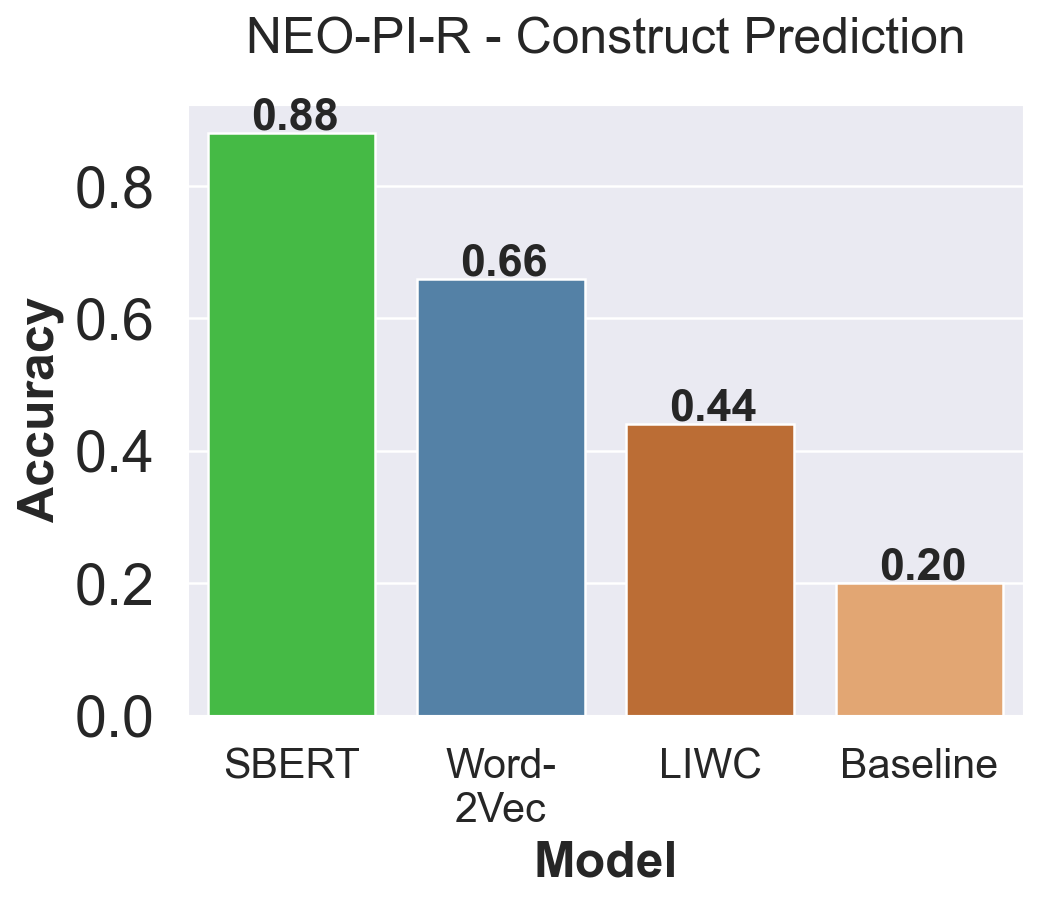

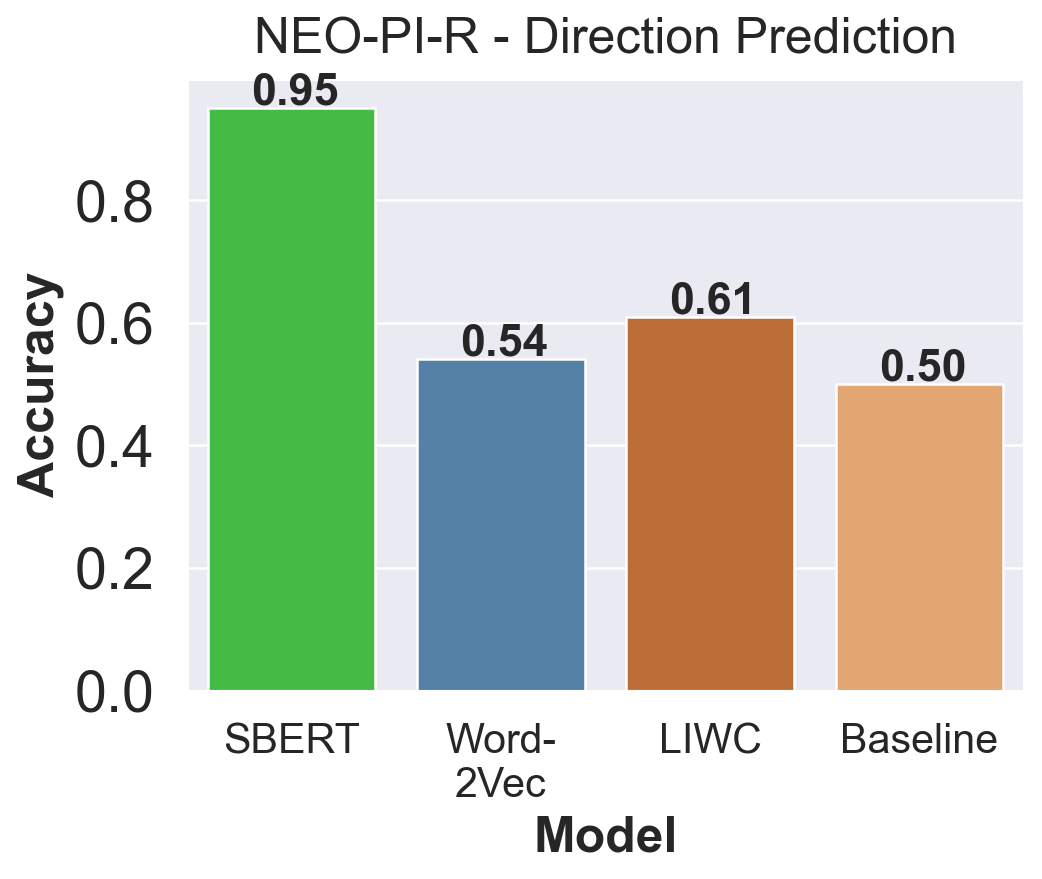

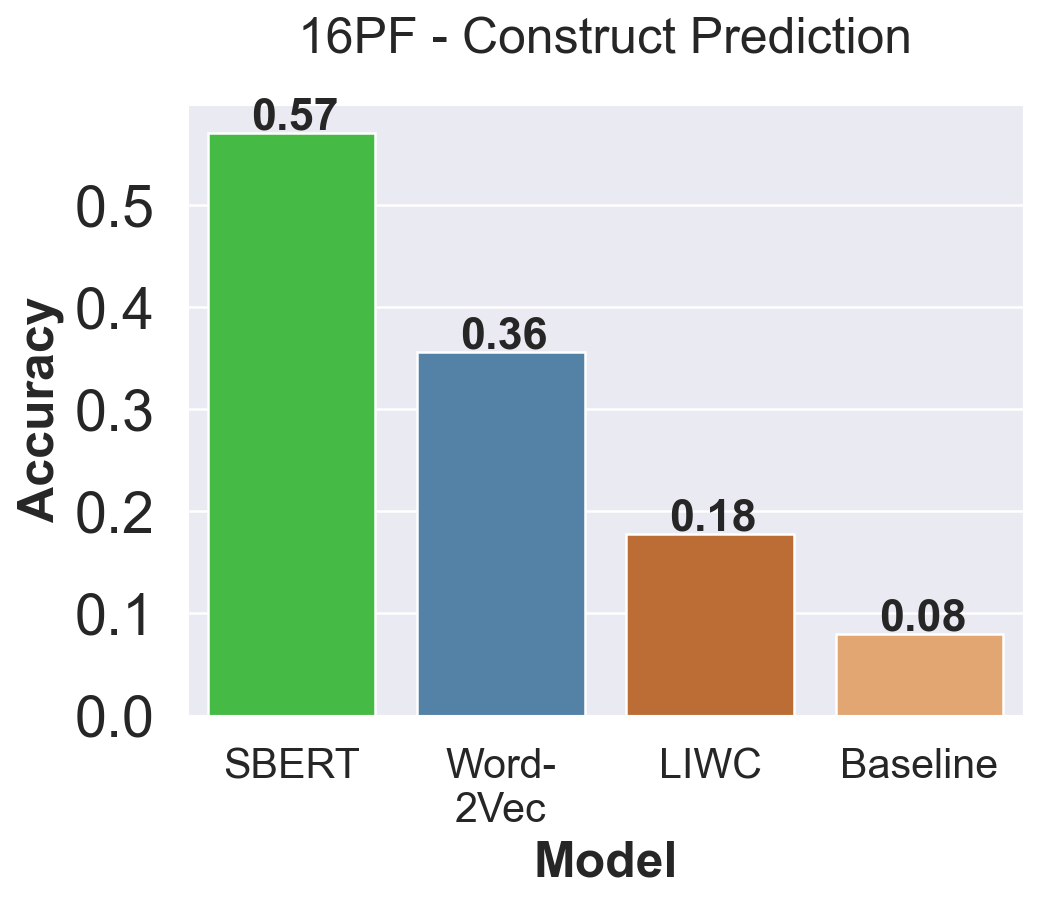

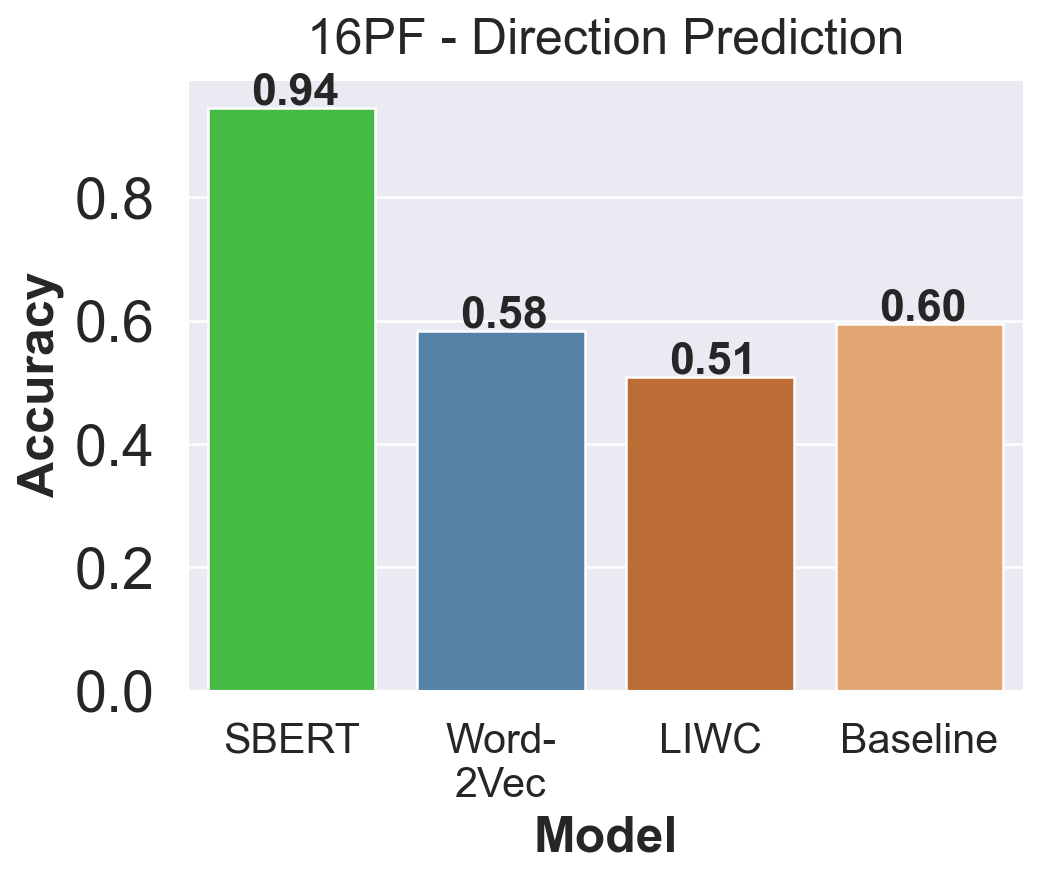

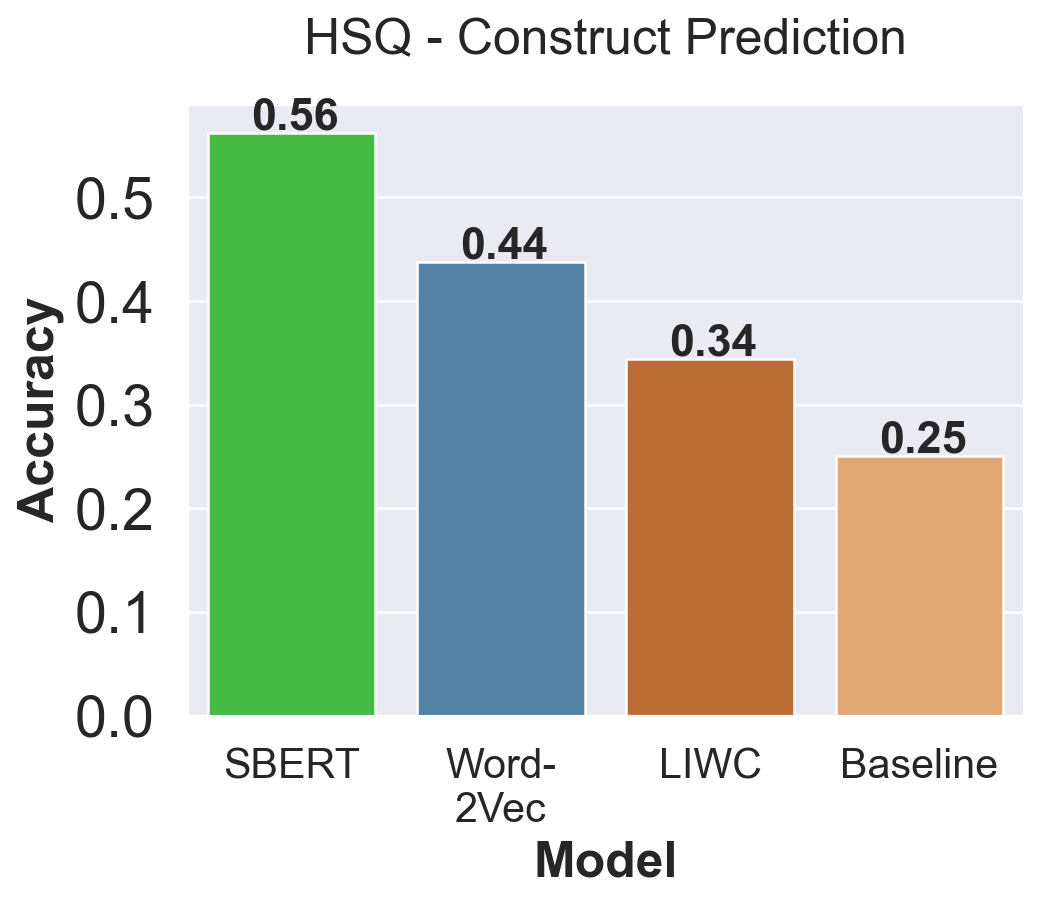

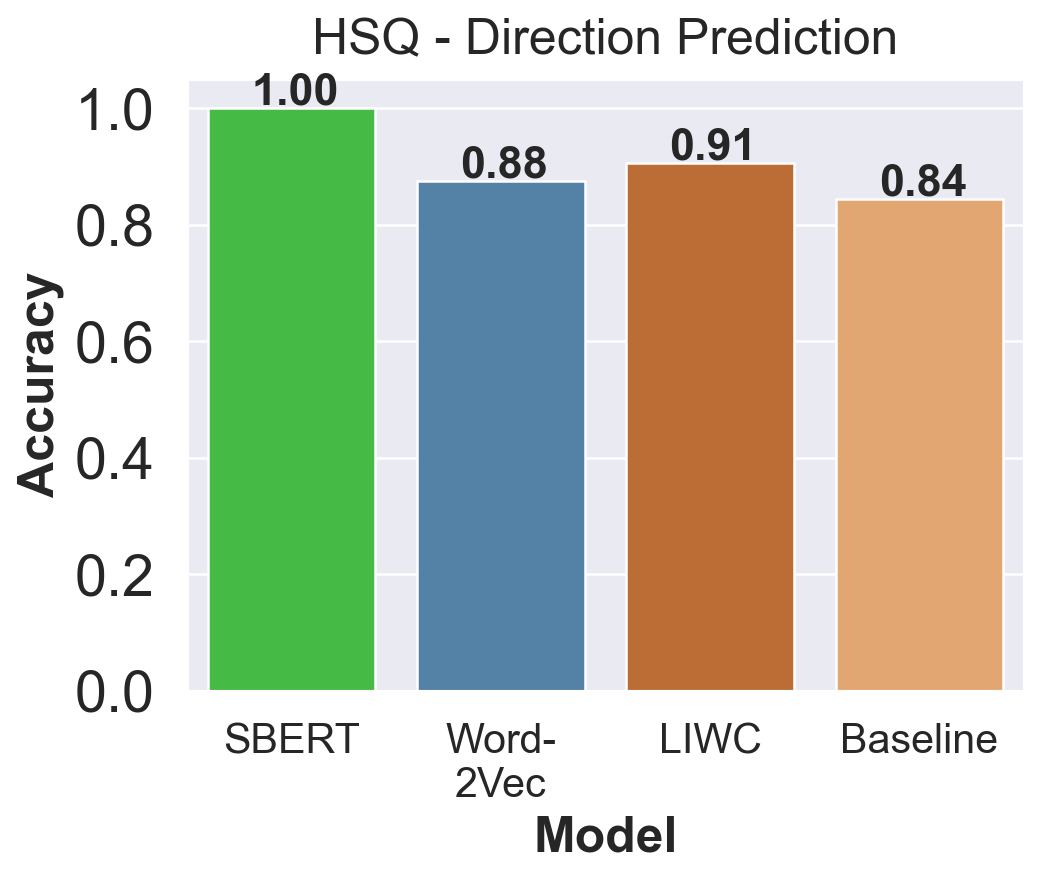

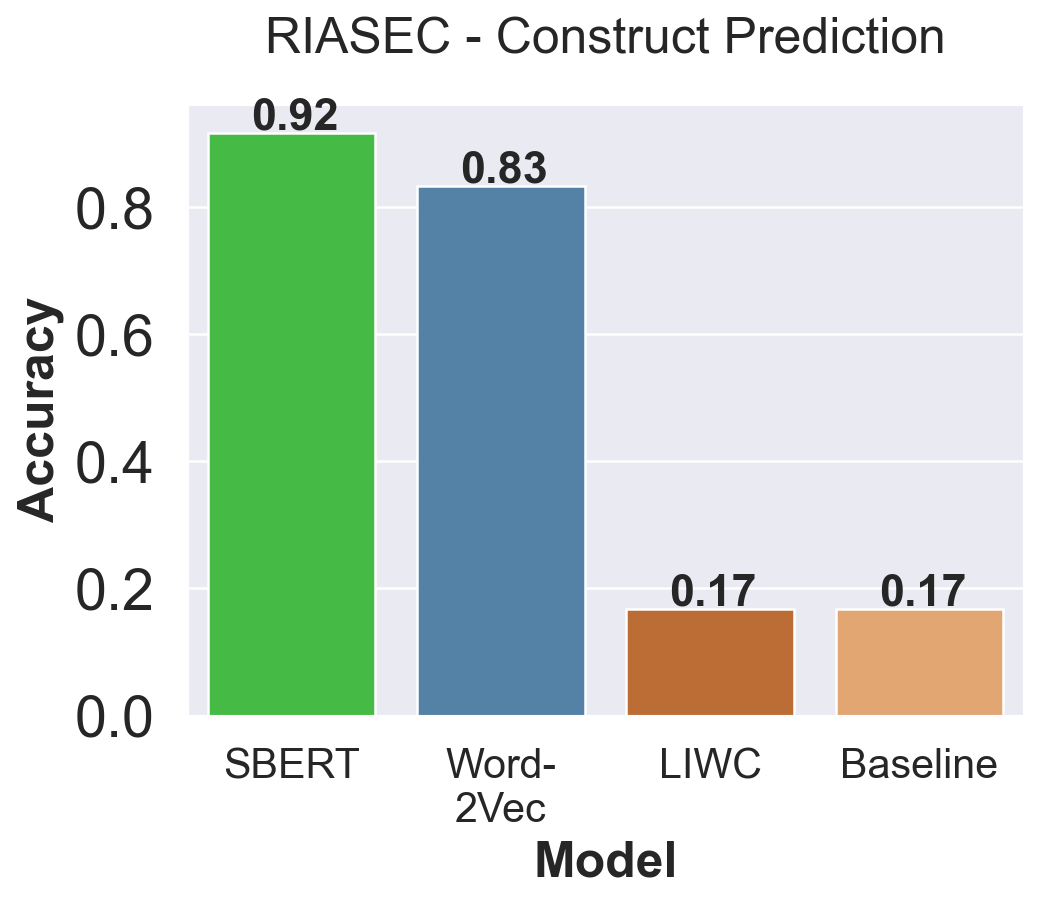

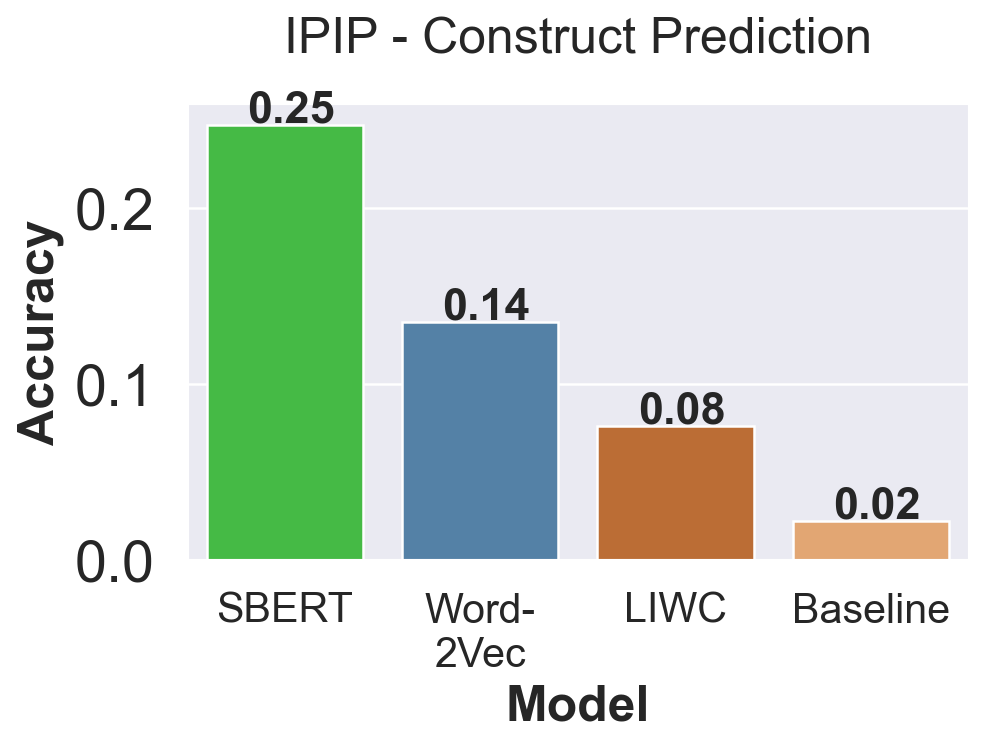

In [116]:
# change to separate panels (subplots)

#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', 'IPIP2']
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', 'IPIP']
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy("construct", i)
  performance_con = performance_con.append(results_con)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy("keys", i)
  performance_dir = performance_dir.append(results_dir)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model'])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_dir['Model']]

#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.5)

l=0 #for labelling of the panels (if only one type of plot is plotted)
for i in range(5):
    # fig.add_subplot(5, 2, 2*i+1)
    fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
    ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC", "Baseline"] , orient='v', data=performance_con[performance_con['Dataset']== datasets_con[i]], 
                     palette=["limegreen", "steelblue", "chocolate", "sandybrown"])
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
              xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

    plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20)
    plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
    plt.yticks(size = 23)
    # ax.set_yticklabels(ax.get_yticks(), size = 20)
    
    fig_name = "plot_data/fig5_" + chr(65+2*i) + ".pdf"
    plt.savefig(fig_name, bbox_inches='tight')

    #Add the direction plots for each data set:
    if i<3:
      # fig.add_subplot(5, 2, 2*i+2)
      fig  = plt.figure(figsize=(6, 4.5), dpi= 180)
      ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC", "Baseline"] , orient='v', data=performance_dir[performance_dir['Dataset']== datasets_dir[i]], 
                      palette=["limegreen","steelblue", "chocolate", "sandybrown"])
      for p in ax.patches:
        if p.get_height() < 0:
          height = -6
        else:
          height = 6
        ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 4, p.get_height()),
                xytext=(18, height), textcoords='offset points', ha="center", va="center", fontweight='bold',fontsize=18)

      plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
      plt.xlabel("Model", fontweight='bold', fontsize=20)
      plt.title(names_dir[i] + " - Direction Prediction", fontsize=20, pad=10)
      plt.yticks(size = 23)
      l=0
      fig_name = "plot_data/fig5_" + chr(65+2*i+1) + ".pdf"
      plt.savefig(fig_name, bbox_inches='tight')
    else:
      l=1


plt.tight_layout()

#### Construct wise performance

Calculate accuracy in the construct and direction prediction tasks for each construct in each dataset. (Does the performance differ across constructs?)

In [13]:
# change to separate panels (subplots)

#new bar plots:
datasets_con = ['BIG5', '16PF', 'HSQ', 'RIASEC', "IPIP2"]
datasets_dir = ['BIG5', '16PF', 'HSQ']
names_con = ['NEO-PI-R', '16PF', 'HSQ', 'RIASEC', "IPIP2"]
names_dir = ['NEO-PI-R', '16PF', 'HSQ']
performance_con = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])
performance_dir = pd.DataFrame(columns=["Dataset", "Model", "Accuracy"])

#iterate through datasets for construct data
for i,nr in zip(datasets_con, range(len(datasets_con))):
  results_con = contextAccuracy_constr("construct", i)
  performance_con = performance_con.append(results_con)

#iterate through datasets for direction data
for i,nr in zip(datasets_dir, range(len(datasets_dir))):
  results_dir = contextAccuracy_constr("keys", i)
  performance_dir = performance_dir.append(results_dir)

cols = performance_con.columns.drop(['Dataset', 'Target', 'Model', "Construct"])
performance_con[cols] = performance_con[cols].astype(float)
performance_dir[cols] = performance_dir[cols].astype(float)

performance_con['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_con['Model']]
performance_dir['Model'] = ["SBERT" if item=="Best Model" else item for item in performance_dir['Model']]
performance_con['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_con['Model']]
performance_dir['Model'] = ["Word-\n2Vec" if item=="WORD2VEC" else item for item in performance_dir['Model']]

running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 
running RidgeClass: 


Print accuracy for construct/direction prediction (by questionnaire)

In [193]:
# Choose questionnaire and print construct names
i = "HSQ"

#print construct names
print("Dataset: " + i)
print("List of construct:")
print(performance_con[performance_con.Dataset == i].Construct.drop_duplicates().tolist()) 
print("\nConstruct prediction performance:\n")

# Print performances for each embedding type over constructs
print(performance_con[performance_con.Dataset == i].to_string())
print("\nDirection prediction performance:\n")

# Print performances for each embedding type over keys
print(performance_dir[performance_dir.Dataset == i].to_string())

Dataset: HSQ
List of construct:
['affiliative', 'selfenhancing', 'aggressive', 'selfdefeating']

Construct prediction performance:

  Dataset        Model  Accuracy     Target      Construct
0     HSQ        SBERT     0.375  construct    affiliative
1     HSQ        SBERT     0.875  construct  selfenhancing
2     HSQ        SBERT     0.500  construct     aggressive
3     HSQ        SBERT     0.500  construct  selfdefeating
0     HSQ         LIWC     0.250  construct    affiliative
1     HSQ         LIWC     0.625  construct  selfenhancing
2     HSQ         LIWC     0.375  construct     aggressive
3     HSQ         LIWC     0.125  construct  selfdefeating
0     HSQ  Word-\n2Vec     0.875  construct    affiliative
1     HSQ  Word-\n2Vec     0.125  construct  selfenhancing
2     HSQ  Word-\n2Vec     0.375  construct     aggressive
3     HSQ  Word-\n2Vec     0.375  construct  selfdefeating
0     HSQ     Baseline     1.000  construct    affiliative
1     HSQ     Baseline     0.000  construc

Print Construct Accuracy for IPIP (top/bottom 5)

In [174]:
n = 20

# calculate performance accuracy over constructs and directions
performance_con_IPIP = performance_con[performance_con.Dataset == "IPIP2"]

top_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").head(n).sort_index().Construct.tolist()
bot_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").tail(n).sort_index().Construct.tolist()

# print accuracies over constructs
print("Construct prediction performance for top 5 constructs:\n")
print(performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr)) & (performance_con_IPIP.Model=="SBERT")])
print("\n")

print("Construct prediction performance for bottom 5 constructs:\n")
# print accuracies over directions
print(performance_con_IPIP[(performance_con_IPIP.Construct.isin(bot_constr)) & (performance_con_IPIP.Model=="SBERT")])

Construct prediction performance for top 5 constructs:

    Dataset  Model  Accuracy     Target                        Construct
33    IPIP2  SBERT     0.941  construct       spirituality/religiousness
48    IPIP2  SBERT     1.000  construct                   health anxiety
57    IPIP2  SBERT     0.900  construct                        gratitude
73    IPIP2  SBERT     0.714  construct               cognitive problems
112   IPIP2  SBERT     1.000  construct            attention to emotions
148   IPIP2  SBERT     0.833  construct                 interest in pets
149   IPIP2  SBERT     0.700  construct                 science interest
153   IPIP2  SBERT     1.000  construct             interest in drinking
154   IPIP2  SBERT     1.000  construct         appearance-consciousness
166   IPIP2  SBERT     1.000  construct             interest in gambling
170   IPIP2  SBERT     0.833  construct            interest in gardening
172   IPIP2  SBERT     0.714  construct             interest in shop

Show construct wise performance as plot

In [43]:
performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr)) | (performance_con_IPIP.Construct.isin(bot_constr))]

Dataset     Model  Accuracy     Target                        Construct
1     IPIP2     SBERT     0.000  construct                       competence
33    IPIP2     SBERT     0.941  construct       spirituality/religiousness
48    IPIP2     SBERT     1.000  construct                   health anxiety
57    IPIP2     SBERT     0.900  construct                        gratitude
112   IPIP2     SBERT     1.000  construct            attention to emotions
..      ...       ...       ...        ...                              ...
154   IPIP2  Baseline     0.000  construct         appearance-consciousness
166   IPIP2  Baseline     0.000  construct             interest in gambling
206   IPIP2  Baseline     0.000  construct                     dissociation
232   IPIP2  Baseline     0.000  construct           interest in journaling
236   IPIP2  Baseline     0.000  construct  interest in watching television

[80 rows x 5 columns]

Show performance as plot

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

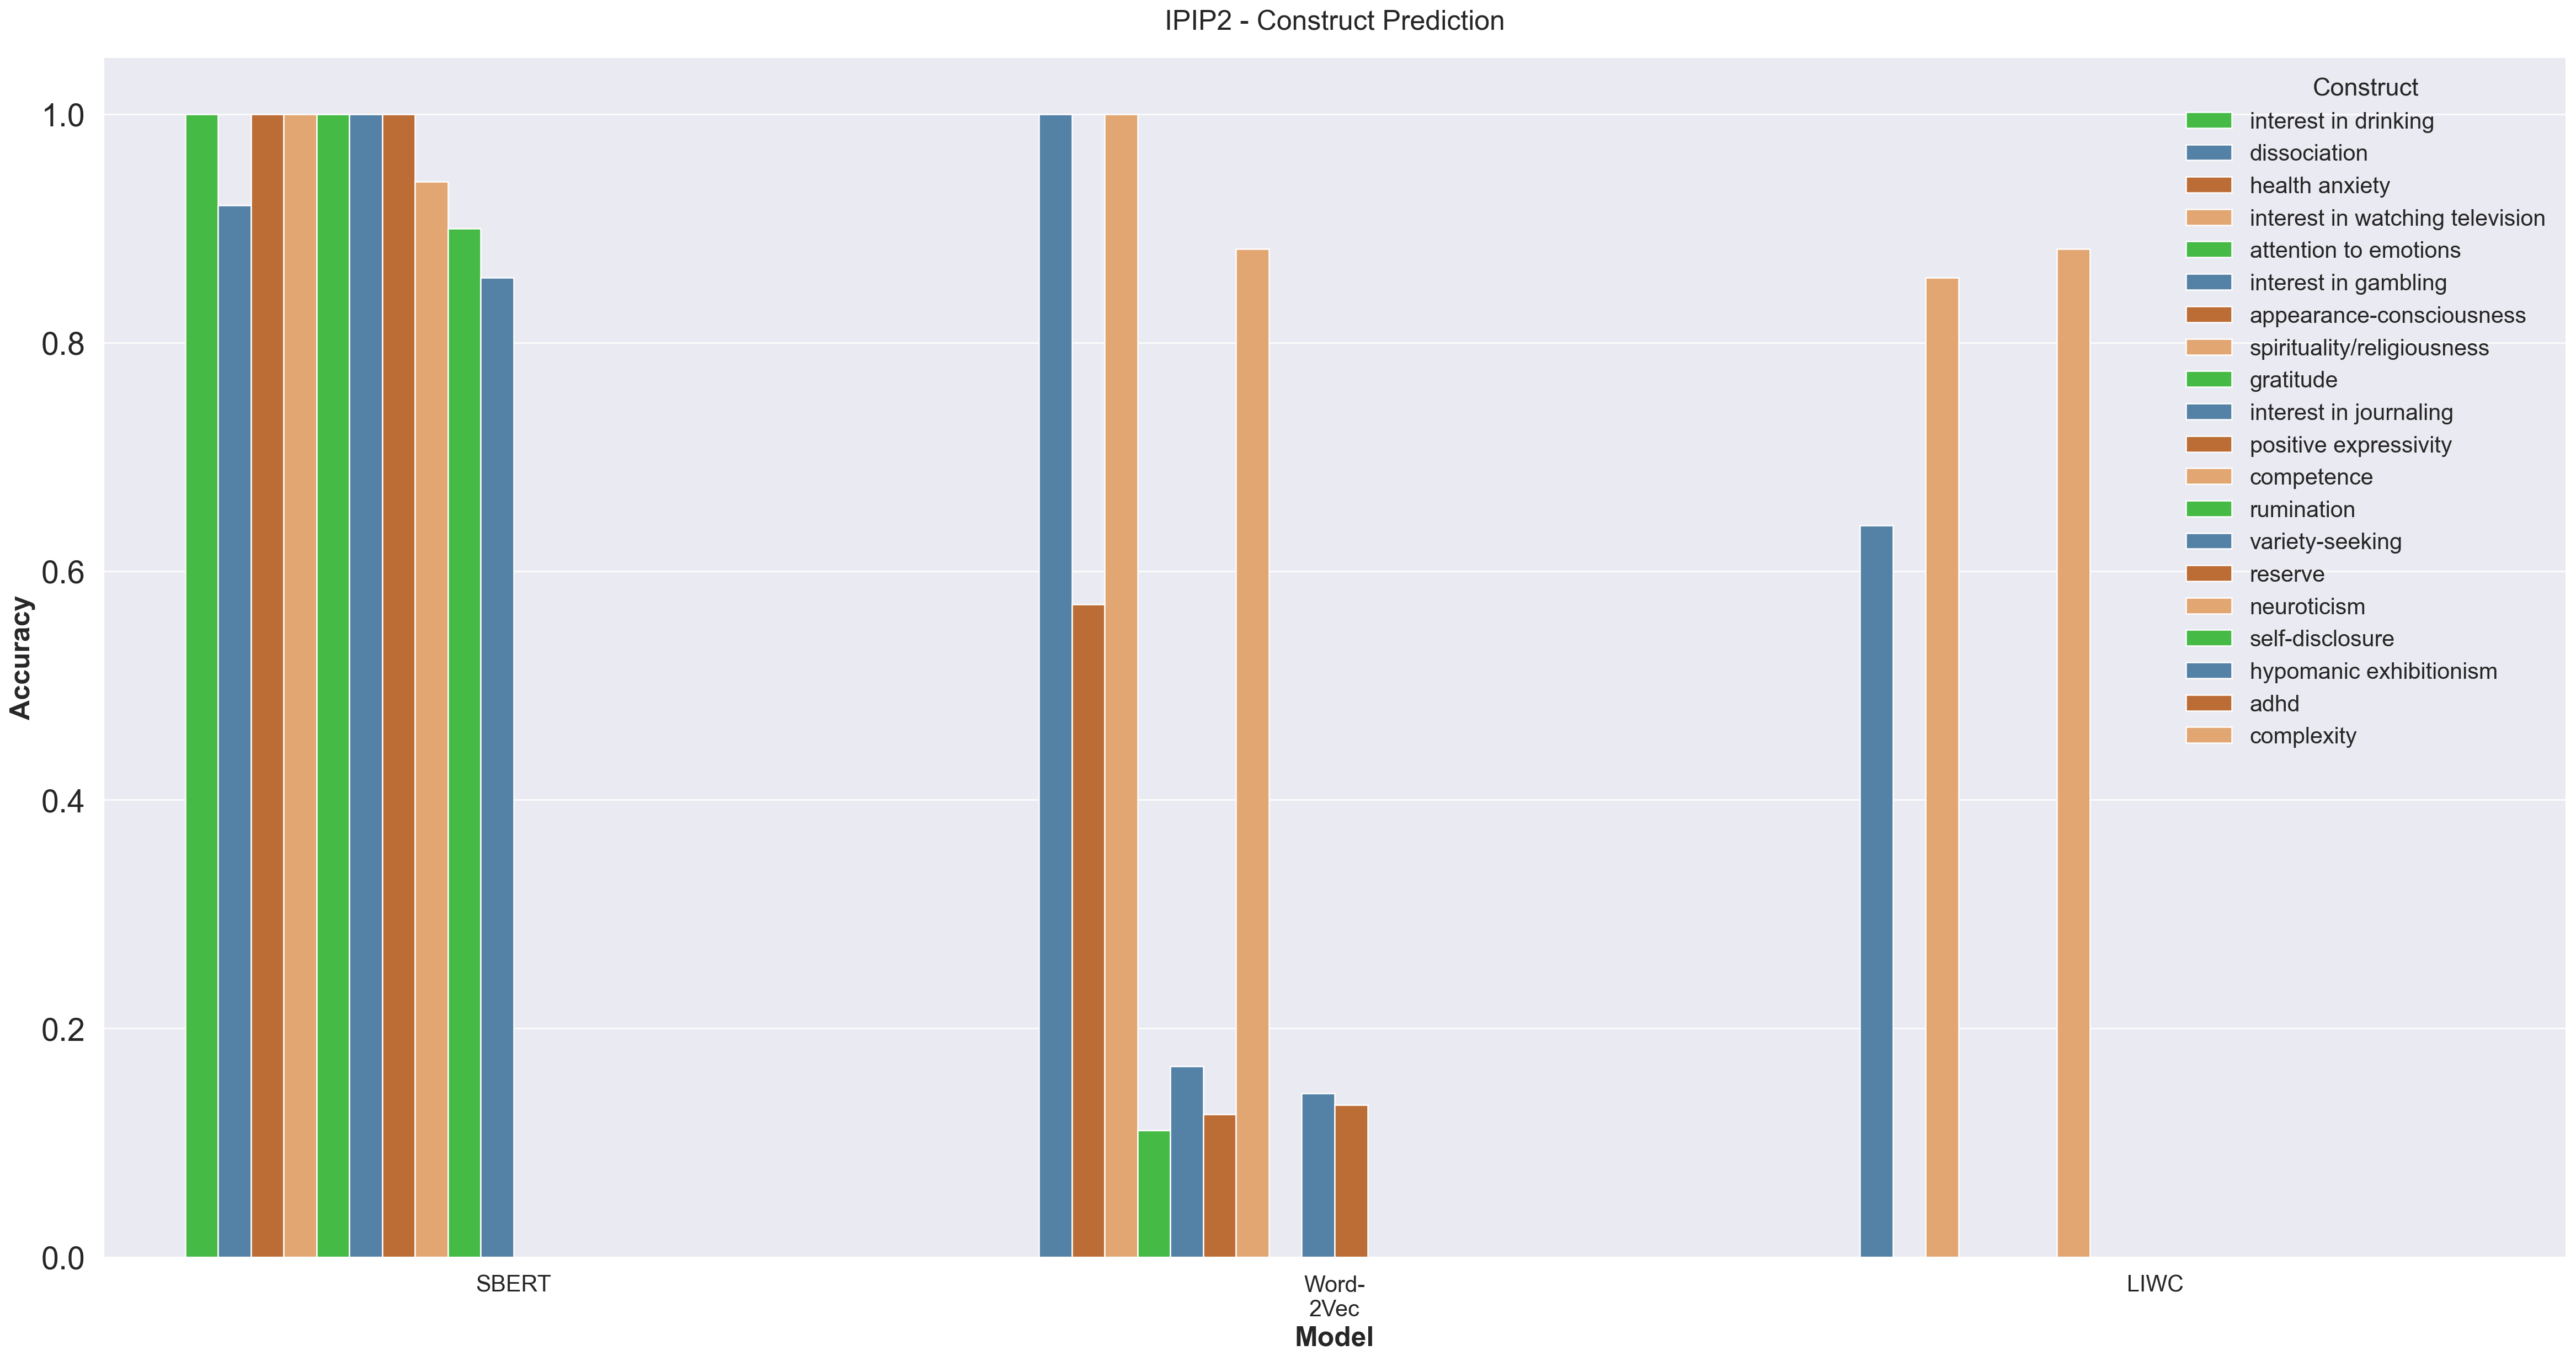

In [192]:
#Plot style and meta
plt.style.use('seaborn')
sns.set_context('paper')
sns.set(font_scale = 1.5)

i = 4

data = performance_con[(performance_con['Dataset']== datasets_con[i]) & (performance_con['Model']!="Baseline")]
if i == 4:
    n = 10
    performance_con_IPIP = performance_con[performance_con.Dataset == "IPIP2"]
    top_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").head(n).sort_index().Construct.tolist()
    bot_constr = performance_con_IPIP[performance_con_IPIP.Model=="SBERT"].sort_values('Accuracy', ascending=False).groupby("Model").tail(n).sort_index().Construct.tolist()
    data = performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr)) | (performance_con_IPIP.Construct.isin(bot_constr))].sort_values("Accuracy", ascending=False)
#     data = performance_con_IPIP[(performance_con_IPIP.Construct.isin(top_constr))]
    fig  = plt.figure(figsize=(32, 16), dpi= 180)
else:
    fig  = plt.figure(figsize=(24, 16), dpi= 180)

ax = sns.barplot(y='Accuracy', x='Model', order=["SBERT", "Word-\n2Vec", "LIWC"], hue = "Construct" , orient='v', data=data, 
                 palette=["limegreen", "steelblue", "chocolate", "sandybrown"])

plt.ylabel("Accuracy", fontweight='bold', fontsize=20)
plt.xlabel("Model", fontweight='bold', fontsize=20)
plt.title(names_con[i] + " - Construct Prediction", fontsize=20, pad=20)
plt.yticks(size = 23)

Show the items and their predicted constructs for a given true label

In [5]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "ipip2"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4           #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

y_constr = constrAssigned.construct.values #get construct values

#dicts to convert number to constructs and vice versa
constrNr = {f: n for n, f in enumerate(constructs_list, 1)} #change construct name to integer for the prediction models
nrConstr = {value:key for key, value in constrNr.items()}
y = pd.DataFrame(np.asarray((list(map(constrNr.get, y_constr)))), index= constrAssigned.index, columns=["constructs"]) #list of labels converted to numbers (1 to n)

running KnnReg: 


In [9]:
construct = "conscientiousness"

items = constrAssigned[constrAssigned.construct.isin([construct])]
idx = items.index
predictions = pd.read_csv("results/IPIP2/nonReversed/RidgeClass_1000_SENTENCEBERT_constructs.csv", index_col=0)
predictions.constructs = predictions.constructs.map(nrConstr)
predictions["original"] = constrAssigned.construct
predictions["text"] = constrAssigned.grammartical_item

predictions.loc[idx]

constructs           original  \
                                                                         
q11                               conscientiousness  conscientiousness   
q174                                       prudence  conscientiousness   
q237       industriousness/perseverance/persistence  conscientiousness   
q396                                    workaholism  conscientiousness   
q818                                 norm violation  conscientiousness   
q961                                   organization  conscientiousness   
q1000      industriousness/perseverance/persistence  conscientiousness   
q1015                                 perfectionism  conscientiousness   
q1238                                    leadership  conscientiousness   
q1300                        creativity/originality  conscientiousness   
q1684      industriousness/perseverance/persistence  conscientiousness   
q1695                             conscientiousness  conscientiousness   
q2232                                  organization  conscientiousness   
q2336                  interest in environmentalism  conscientiousness   
q2337      industriousness/perseverance/persistence  conscientiousness   
q2338                             conscientiousness  conscientiousness   
q2554                                   orderliness  conscientiousness   
q2744                                 perfectionism  conscientiousness   
q2849  risk-taking/sensation-seeking/thrill-seeking  conscientiousness   
q2971                  interest in environmentalism  conscientiousness   
q3184                                activity-level  conscientiousness   

                                         text  
                                               
q11              i accomplish my work on time  
q174    i am careful to avoid making mistakes  
q237                 i am exacting in my work  
q396                  i am often late to work  
q818                            i break rules  
q961                     i carry out my plans  
q1000           i complete tasks successfully  
q1015  i continue until everything is perfect  
q1238                     i do not plan ahead  
q1300        i do things in a half-way manner  
q1684                   i finish what i start  
q1695          i follow through with my plans  
q2232            i keep my checkbook balanced  
q2336            i leave my belongings around  
q2337                  i leave my work undone  
q2338               i leave things unfinished  
q2554                 i make a mess of things  
q2744              i pay attention to details  
q2849              i put off unpleasant tasks  
q2971                 i return borrowed items  
q3184                i take tasks too lightly

Save results

In [ ]:
predictions.to_csv("results/IPIP2/nonReversed/RidgeClass_1000_SENTENCEBERT_constructs_predictions.csv", index = True)

### Visualising Question Embeddings: Wordclouds

Define Dataset and embeddings type:

In [ ]:
d = "ipip"          #IPIP: all items, IPIP2: only assigned
e = "sentencebert"
nAssigned = 1       #0: only assigned items, #1: include non-assigned items

#choose data set, embeddings, encoding
folder, data = chooseData(d)        
#read in embeddings and save in vector
embeddings_df = pd.read_csv("embeddings/" + folder + 'ipip_full_questions_embeddings_SENTENCEBERT.csv',index_col=0)
constrAssigned = pd.read_csv("embeddings/" + folder + "ipip_questions_text.csv", encoding = 'utf-8',index_col=0)
X = embeddings_df.copy()

# ################################ Preprocess input data::
#Standardize for regression (wihtout PCA)
X_stand = pd.DataFrame(StandardScaler().fit_transform(X)) #standardize embeddings
#With PCA, for regression, 90% variance explained
X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=embeddings_df.index) 

Clustering based on question embeddings

In [ ]:
#Number of clusters
k = 9
#include/exclude non assigned items
nAssigned = 1

if nAssigned == 0:
  plt_emb = X_pca.iloc[np.where(constrAssigned.construct != 'not assigned')]
else:
  plt_emb = X_pca

#K-Means clustering
model = KMeans(n_clusters = k, random_state=2)
model.fit(plt_emb)
yhat = model.predict(plt_emb)

#create a dataframe that contains all items grouped by cluster
itemlist = constrAssigned.loc[plt_emb.index,'item'].drop_duplicates() #get the item texts
clusterOverview = pd.DataFrame(np.full((1,k),0))
clusters = []
for i in range(k):
  clusters.append(np.where(yhat==i)[0]) #get item indices for each cluster
find = list(range(len(itemlist)))
replace = itemlist
clusterOverview = pd.DataFrame(clusters).T.replace(find, replace) #replace the indices with item texts

#### Define Functions for preprocessing

In [ ]:
#load libraries and define preprocessing function (most preprocessing has already been done previously for other tasks)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

import nltk
import re
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Define tokenisation functions
def preprocess(items):
  #remove symbols
  symbols = "!#$%&()*+-./:;<=>?@[\]^_`{|}~"
  for i in symbols:
      items = [word.replace(i, ' ') for word in items]
  docs = [[lemmatizer.lemmatize(word) for word in sublist.split()] for sublist in items] #lemmatise
  items = [" ".join(sublist) for sublist in docs] #unflatten list
  return items, docs

#### Find most frequent terms in the IPIP

In [ ]:
texts = pd.DataFrame(clusterOverview.values.flatten()).dropna().values.flatten()
docs = texts.tolist() #all items as individual strings in list

#preprocess: remove symbols, stopwords, lemmatise, stemming
total_items, total_docs = preprocess(docs)
#eliminate basic stop words
# stopwords=stop_words.ENGLISH_STOP_WORDS
sp_words, _ = preprocess(STOP_WORDS)
sp_words.extend(["'ll", "'ve"]) #add additional stop words that are not created in preprocessing

# use tf-idf, calculate frequencies and find the most frequent ones in the document -> add to stop words list
vec=TfidfVectorizer(max_df=0.85,stop_words=sp_words, preprocessor=lambda x: re.sub(r'(\d[\d\.])+', '', x.lower()))
tfidf_vector=vec.fit_transform(total_items)
feature_names = vec.get_feature_names()
dense = tfidf_vector.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
frequency = df.T.sum(1)

# remove words frequent across all documents -> improve wordclouds by removing too generic terms
a = list(sp_words)
a.extend(frequency.sort_values()[::-1][0:10].index.tolist())

#### Plot Word Clouds

In [ ]:
#create word clouds for each cluster
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    c1 = round(random.randint(50, 90),3)
    c2 = round(random.randint(30, 50),3)
    return "hsl(235, " + str(c1) + "%, " + str(c2) + "%)"

for nc in range(clusterOverview.shape[1]):
  # preprocess
  cluster_texts = clusterOverview[nc].dropna().values # all cluster item texts
  cluster_items, cluster_docs = preprocess(cluster_texts)
  Cloud = WordCloud(background_color="white", stopwords=a, max_words=85, random_state=0, collocations=False, width=1920, height=1080).generate(" ".join(cluster_items))#.generate_from_frequencies(cluster_frequency)
  plt.figure(figsize=(20,10))
  plt.imshow(Cloud, interpolation='bilinear')
  plt.imshow(Cloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
  plt.axis("off")
  plt.show()

#### Check which constructs are in the clusters

In [ ]:
#get the constructs from the IPIP that are in our new clusters
clusterConstructs = pd.DataFrame()
for i in range(clusterOverview.shape[1]):
  items = clusterOverview.iloc[:,i]
  #get construct
  constructs_idx = np.where(constrAssigned.item.isin(items))[0]
  constructs = constrAssigned.construct[constructs_idx].values
  #summarise which constructs occur how often
  summary = Counter(constructs)
  #get 5 (excluding "not assigned") most frequent one with number:
  clusterConstructs[i] = summary.most_common(10)
clusterConstructs

Find items of interest in a cluster

In [ ]:
cl = 8 #cluster
search = "love" #search word
mask = clusterOverview.iloc[:,cl].str.contains(search).fillna(False)
df = clusterOverview.loc[(mask),clusterOverview.columns[cl]].copy(deep=True)
df

### Construct/Item similarities

Check if items in same constructs are more similar than items across constructs, using pairwise cosine similarity of item embeddings (average pairwise similarity for same construct vs across construct item pairs).

running KnnReg: 




BIG5
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     103.5
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          3.28e-104
Time:                        01:49:04   Log-Likelihood:                 2757.0
No. Observations:                4950   AIC:                            -5502.
Df Residuals:                    4944   BIC:                            -5463.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2898     

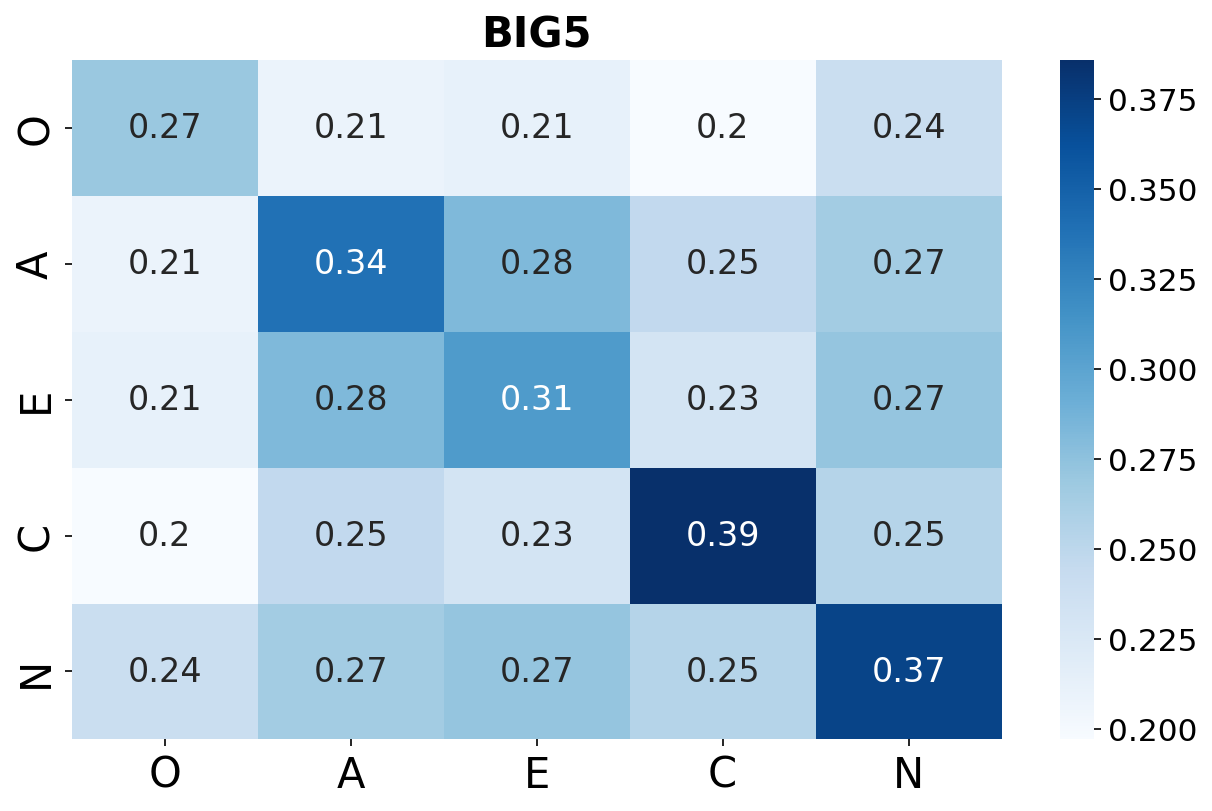





HSQ
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     8.744
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           7.98e-07
Time:                        01:49:04   Log-Likelihood:                 244.77
No. Observations:                 496   AIC:                            -479.5
Df Residuals:                     491   BIC:                            -458.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5785      0.022   

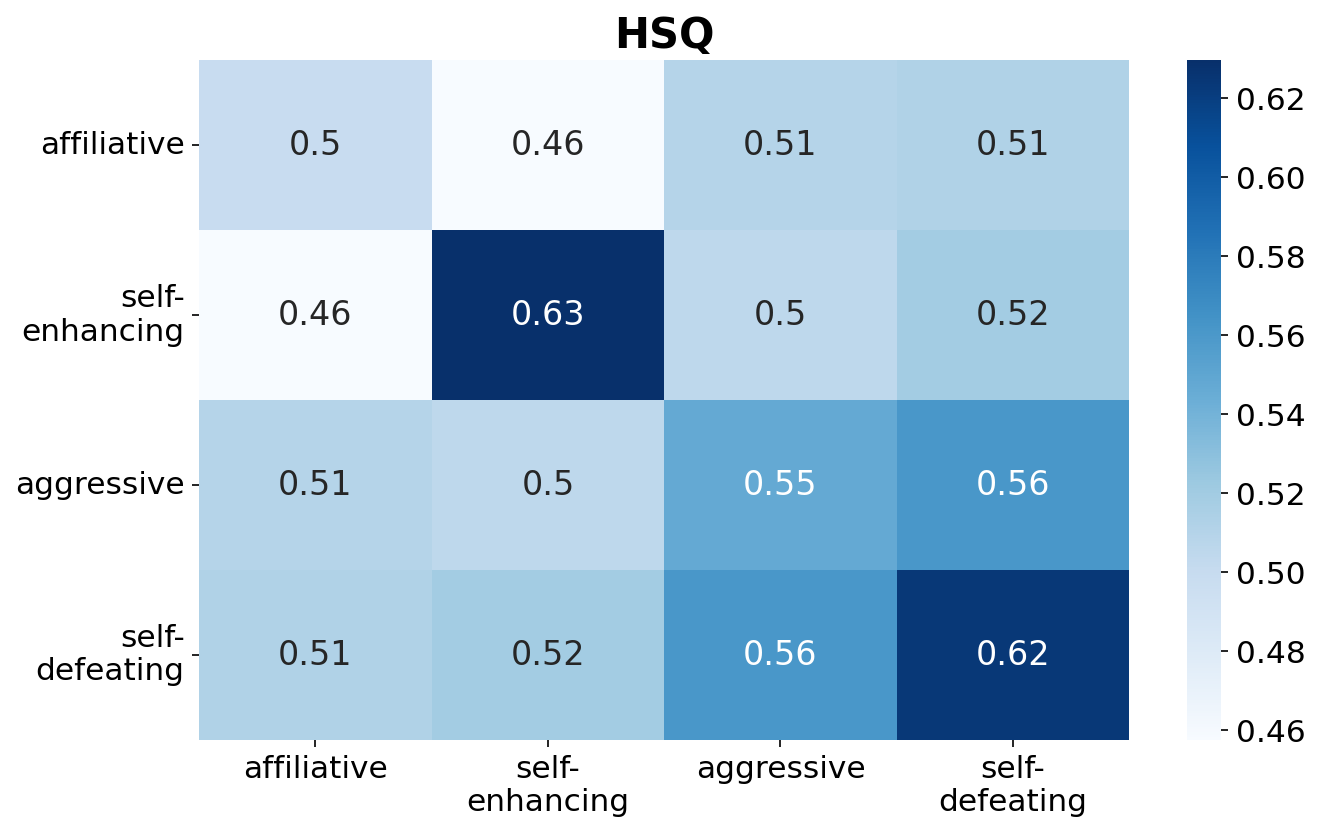

Index(['Realistic', 'Investigative', 'Artistic', 'Social', 'Enterprising',
       'Conventional'],
      dtype='object')




RIASEC
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     66.10
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           1.99e-70
Time:                        01:50:44   Log-Likelihood:                 1044.5
No. Observations:                1128   AIC:                            -2075.
Df Residuals:                    1121   BIC:                            -2040.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.9

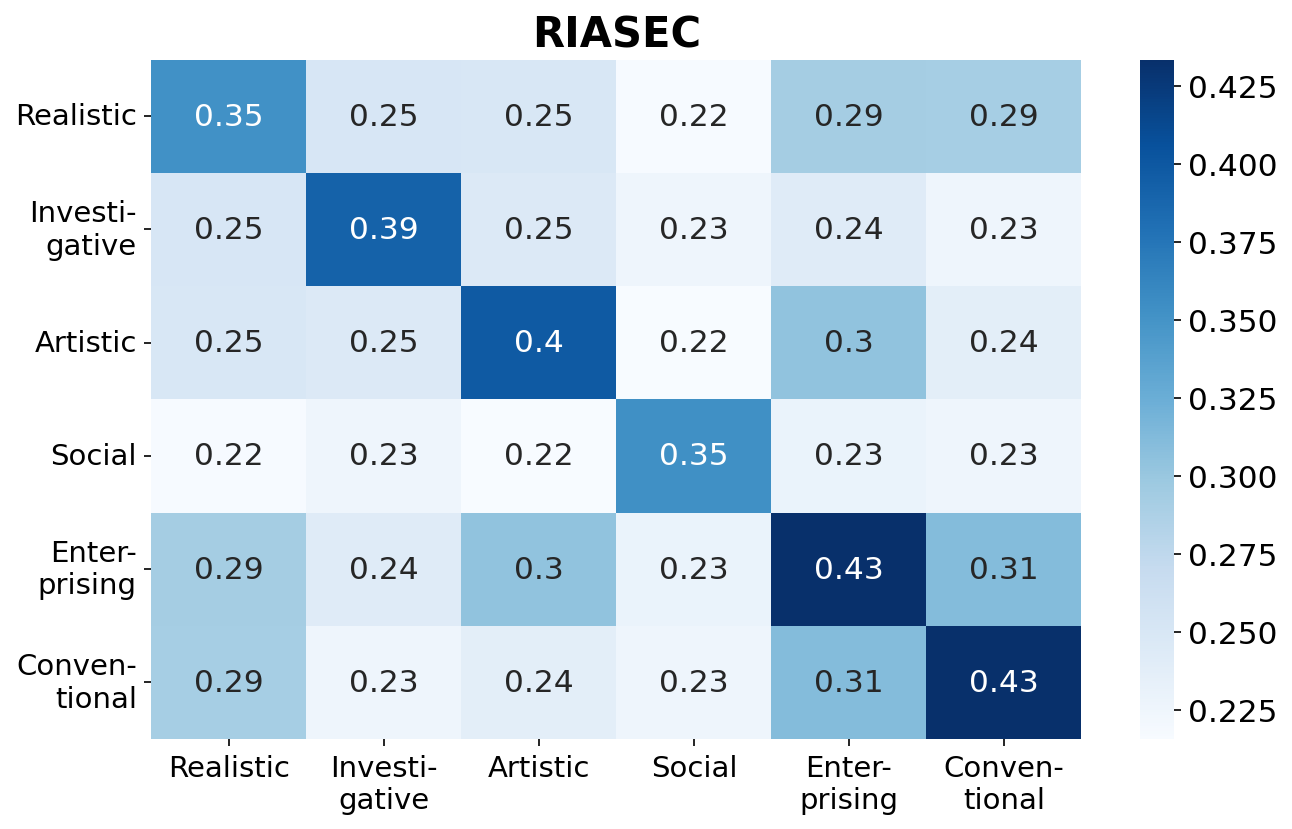





16PF
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     58.10
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          5.09e-181
Time:                        01:51:01   Log-Likelihood:                 7540.5
No. Observations:               13203   AIC:                        -1.505e+04
Df Residuals:                   13186   BIC:                        -1.492e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3316      0.007     47.313

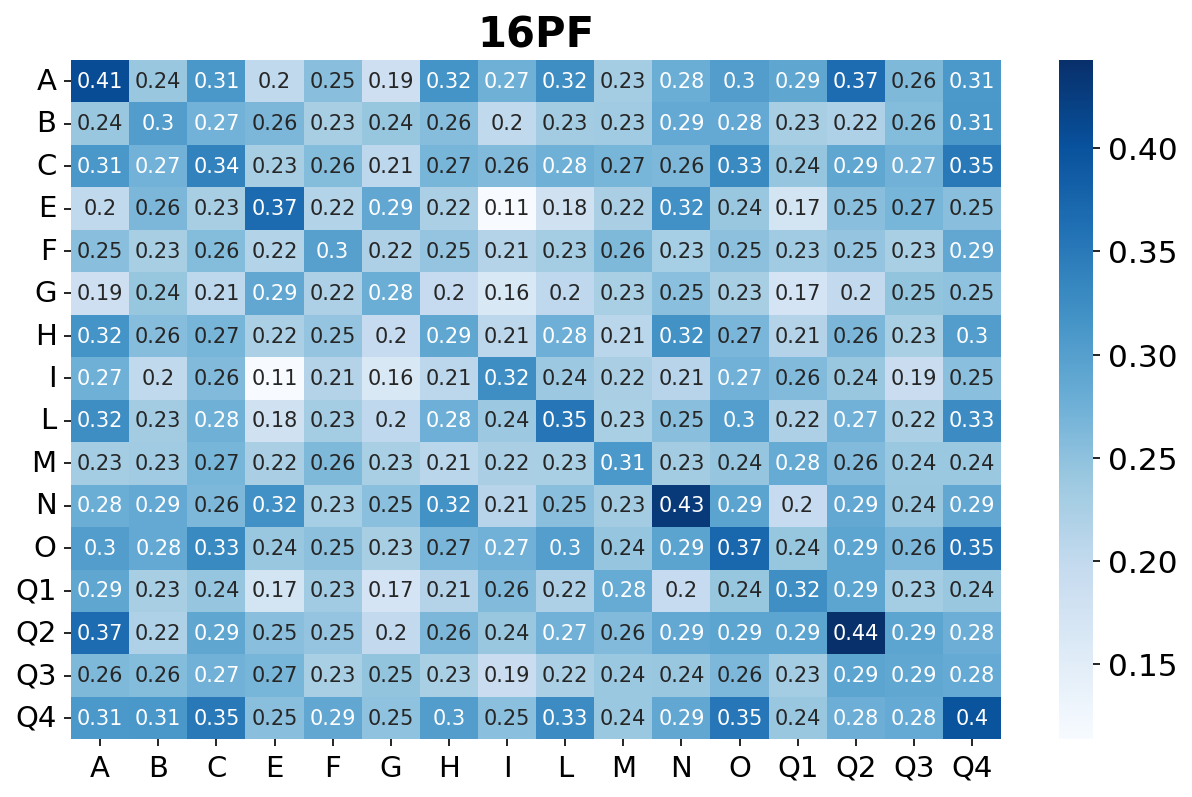

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import statsmodels.formula.api as sm
import itertools

# BIG5

#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
datasets = ["BIG5", 'HSQ', 'RIASEC', "16PF"]
# d = "BIG5"      #BIG5, 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 


#load path and necessary variables:
for d in datasets:
  folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
  embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
  responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
  responses = responses.astype(float) #get observed responses as floats
  X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

  # import required data and labels:
  data_q, constructs_list, list_par, constrAssigned = getData(1)

  #calculate construct similarities
  item_values = pd.DataFrame(columns=constructs_list, index=constructs_list)
  item_groups = pd.DataFrame(columns=constructs_list, index=constructs_list)
  sim_df = pd.DataFrame(columns=constructs_list, index=constructs_list)
  for constr_A in constructs_list:
    idx_A = np.where(constrAssigned.construct == constr_A)[0]
    for constr_B in constructs_list:
      idx_B = np.where(constrAssigned.construct == constr_B)[0]
      if constr_B == constr_A:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity_cleaned = []
        for i in range(sim.shape[0]):
          temp = sim[i][i+1:]
          similarity_cleaned.extend(temp)
        sim = similarity_cleaned
        similarity = np.array(sim).mean()
        item_values.loc[constr_A, constr_B] = sim        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim)
      else:
        sim = cosine_similarity(X.iloc[idx_A], X.iloc[idx_B])
        similarity = sim.mean()
        item_values.loc[constr_A, constr_B] = sim.flatten().tolist()        #save item level similarity over the whole constructs
        item_groups.loc[constr_A, constr_B] = [constr_A + "-" + constr_B]*len(sim.flatten().tolist())
      sim_df.loc[constr_A, constr_B] = similarity      #save average similarity
  sim_df = sim_df.astype(float)

  # change construct name to make it shorter to fit into figure
  if d=="BIG5":
    construct_list = sim_df.columns
  elif d=="HSQ":
    construct_list = sim_df.columns
    construct_list = ["self-\nenhancing" if item=="selfenhancing" else item for item in construct_list]
    construct_list = ["self-\ndefeating" if item=="selfdefeating" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  elif d=="RIASEC":
    construct_list = sim_df.columns
    print(construct_list)
    construct_list = ["Investi-\ngative" if item=="Investigative" else item for item in construct_list]
    construct_list = ["Enter-\nprising" if item=="Enterprising" else item for item in construct_list]
    construct_list = ["Conven-\ntional" if item=="Conventional" else item for item in construct_list]
    sim_df.columns = construct_list
    sim_df.index = construct_list
  if d=="16PF":  
    construct_list = sim_df.columns 


  #show plots
  fig, ax = plt.subplots(figsize=(10, 6), dpi = 150) #figure specs
  if d=="BIG5":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="HSQ":
    # sns.set(font_scale=1.5)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":16})
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="RIASEC":
    # sns.set(font_scale=1.3)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":15})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
  elif d=="16PF":
    # sns.set(font_scale=0.7)
    sns.heatmap(sim_df, annot=True, cmap="Blues", annot_kws={"fontsize":10})
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
    
  ########################### test for significance:

  print("\n\n\n")
  print(d)

  outclass_values = []
  outclass_groups = []
  inclass_values = []
  inclass_groups = []

  for n in range(len(constructs_list)):
    if n!= len(constructs_list)-1:
      outclass_values.extend(list(itertools.chain.from_iterable(item_values.iloc[n+1:,n]))) #items below diagonal are between constructs (matrix is symmetric so only take values below diagonal)
      outclass_groups.extend(list(itertools.chain.from_iterable(item_groups.iloc[n+1:,n]))) #get the names of the item pairs' constructs
    inclass_values.extend(item_values.iloc[n,n]) #values on the diagonal are within construct
    inclass_groups.extend(item_groups.iloc[n,n]) 

  outclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  outclass_df.similarity = outclass_values
  outclass_df.construct_1 = [x.split("-")[0] for x in outclass_groups]
  outclass_df.construct_2 = [x.split("-")[1] for x in outclass_groups]
  outclass_df.in_class = [0]*len(outclass_values)
  
  inclass_df = pd.DataFrame(columns=["in_class", "similarity", "construct_1", "construct_2"])
  inclass_df.similarity = inclass_values
  inclass_df.construct_1 = [x.split("-")[0] for x in inclass_groups]
  inclass_df.construct_2 = [x.split("-")[1] for x in inclass_groups]
  inclass_df.in_class = [1]*len(inclass_values)
  merged_df = pd.concat([inclass_df,outclass_df])
  
  c1 = pd.get_dummies(merged_df["construct_1"])
  c2 = pd.get_dummies(merged_df["construct_2"])
  combined = c1 | c2

  final_df = pd.concat([merged_df.iloc[:,:-2], combined], axis=1)

  model = sm.ols(formula = "similarity ~ in_class + " + "+".join(constructs_list[:-1]), data=final_df)
  res = model.fit()
  A = np.identity(len(res.params))[1:,:]
  print(res.summary())
  print('R2: ', res.rsquared)
  print(res.f_test(A))  

  #save figures
  fig_name = "plot_data/similarities_" + d + ".pdf"
  plt.title(d, fontsize=20, fontweight="bold")
  plt.savefig(fig_name, bbox_inches='tight')

  plt.show()

# Reverse-coding responses (auxiliary code)

Import responses

In [ ]:
#data:
d = "hsq"         # BIG5, IPIP2, RIASEC, HSQ,

#choose data set, embeddings, encoding
folder, data = chooseData(d) 
embeddings, save = chooseEmb('sentencebert') 
responses, _, _, _ = getResponses(folder, data, 1)
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)
_, _, _, constrAssigned = getData(1)

#rename:
responses_df = responses
questions_df = constrAssigned

Check min/max values, removing non-defined values (out of scale)

In [ ]:
# # check max values
print(responses_df.max().max())
print(responses_df.min().min())

# remove all rows with 0
#responses_df = responses_df.iloc[:,:-2]
responses_df = responses_df[(responses_df != 0).all(1)]
responses_df = responses_df[(responses_df != -1).all(1)]

responses_df.shape #check dataframe dimensions

Reversing responses

In [ ]:
# Changing from reverse-coded to non-reverse-coded and vice versa

max_response_value = responses_df.values.max() #find max value

#find questions that have to be reversed coded
question_key = questions_df.encoding == -1           

#flip responses
responses_df.loc[:,question_key] = max_response_value - responses_df.loc[:,question_key] + 1

Save reversed responses

In [ ]:
#responses_df.to_csv(dataset_path+folder+data+"responses.csv", header=True)

# Human rater evaluation

Load best model

In [ ]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

#get performance:
corr, means = corrUserBased(total_preds, responses)

Confidence interval function

In [ ]:
import math

def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf((1 + alpha)/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

Find Target Participants

In [ ]:
error = 0.0001 # for rounding errors
sorted = corr.sort_values("Correlation")
S = sorted.Correlation
P = sorted['p-value']

for q in [0.25, 0.5, 0.75]:
  percentage_rank = S.rank(method="max", pct=True)
  idx = S.index[percentage_rank >= q-error]
  print('Target ID: ' + idx[0])
  print("Correlation: " + str(S[idx[0]]))
  print("p-value: " + str(P[idx[0]]))
  CI = r_confidence_interval(S[idx[0]], 0.95, responses.shape[1])
  print("CI: [" + str(CI[0]) + ", " + str(CI[1]) + "]")
  print("\n")

## Analysing Outliers

In [ ]:
# load target data
xslx = pd.ExcelFile("results/human_eval_unreversed.xlsx")
target_25 = pd.read_excel(xslx, "25%", index_col=0)
target_50 = pd.read_excel(xslx, "50%", index_col=0)
target_75 = pd.read_excel(xslx, "75%", index_col=0)
target_list = [(target_25, "25%"), (target_50, "50%"), (target_75, "75%")]

# get performance for human raters and prediction model
n_steps = 10
cor_h,p_h,cor_comp,p_comp = regCorr(target_list, n_steps, predictions_targets) #correlations

# sort values
sorted = corr.sort_values("Correlation")
S = sorted.Correlation
P = sorted['p-value']
targets = []

# get participant ids at 1%, 5%, 95% and 99% percentile
for q in [0.01, 0.05, 0.95, 0.99]:
  percentage_rank = S.rank(method="max", pct=True)
  idx = S.index[percentage_rank >= q]
  targets.append(idx[0])

Compare a high performing and low performing target!

lowest performance

In [ ]:
pd.set_option('display.max_rows', None)

## How does the training responses look like for the low performer?
## How does the training responses look like for the high performer

nr = 0 # lowest 1 percentile
responses = pd.read_csv("embeddings/BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts
(df, df_name) = target_list[1]
x = responses.loc[:, targets[nr]].values
x = x[df.index].reshape(10,10)
y = predictions.loc[targets[nr],:].values
y = y[df.index].reshape(10,10)

fold = 0 # choose test fold to investigate

test_texts = question_texts.iloc[df.index.values.reshape(10,10)[fold]][["grammartical_item", "construct"]]    
test_texts["response"] = x[fold]
test_texts["prediction"] = y[fold]
training_folds = [i for i in range(df.index.values.reshape(10,10).shape[0]) if i!=fold]
training_idx = df.index.values.reshape(10,10)[training_folds]
training_texts = question_texts.iloc[(df.index.values.reshape(10,10)[training_folds]).flatten()][["grammartical_item", "construct"]]    
training_texts["response"] = x[training_folds].flatten()

# print(pearsonr(x,y))
# print(test_texts)
# print(training_texts)

In [ ]:
constr = "N"
print(test_texts[test_texts.construct == constr])
print(training_texts[training_texts.construct == constr])

# O:  Very non-open person with some liberal leanings and enjoys new ideas and neutral for philosophical discussions
#     Predictions for non-open items are too low (high values on some subfacets influence the predictions)

# C:  Correct predictions: Mixed conscientiousness. Wastes time, not detailed and difficulty getting down to work, but if getting down to work then works exactly, successfully, follows through with plans
#     Response prediction for questions seem to be a blend of related items across facets/subfacets

# E:  Prediction too low: Very extraverted person but keeps in the background -> prediction mixes liking attention with being in the background to a medium (3) prediction when the response was 5

# A:  Somehwat unagreeable person with mixed responses on the facets: e.g. agressive, and does not have a good word for others but also accepts people and concerned 
#     Prediction as medium (1 too low) for trusting others
#     Prediction as medium (1 too high) for treating people equally (probably because person accepts others as they are)

# N:  Predictions too low because of contradicting responses on related facets (very low on some and high on others)
#     E.g., person does not get irritated easily and is comfortable with themselves but also panics and is easily frustrated

highest performance

In [ ]:
nr = 3 #highest 99 percentile
responses = pd.read_csv("embeddings/BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts
x = responses.loc[:, targets[nr]].values
x = x[df.index].reshape(10,10)
y = predictions.loc[targets[nr],:].values
y = y[df.index].reshape(10,10)

fold = 0 # choose test fold to investigate

test_texts = question_texts.iloc[df.index.values.reshape(10,10)[fold]][["grammartical_item", "construct"]]    
test_texts["response"] = x[fold]
test_texts["prediction"] = y[fold]
training_folds = [i for i in range(df.index.values.reshape(10,10).shape[0]) if i!=fold]
training_idx = df.index.values.reshape(10,10)[training_folds]
training_texts = question_texts.iloc[(df.index.values.reshape(10,10)[training_folds]).flatten()][["grammartical_item", "construct"]]    
training_texts["response"] = x[training_folds].flatten()

# print(pearsonr(x,y))
# print(test_texts)
# print(training_texts)

In [ ]:
constr = "N"
print(test_texts[test_texts.construct == constr])
print(training_texts[training_texts.construct == constr])

# O:  Slightly too high prediction on one question. Very open person but has a few slightly lower loadings 
#     on things like abstract ideas (might have influenced the one skewed question, on deeper meaning in things) 

# C:  Correct predictions: Very conscientious but waists some time and needs a push to get started -> estimates making plans correctly

# E:  Correct prediction:
#     Training questions very low on anything about approaching others, being the center of attention etc. But medium to high on talking in general 
#     I have a lot to say, i am somehwat easy to get to know, i dont really avoid contact with others -> Predictions correct for related social skills but somewhat too high for starting conversation
#     It seems that this person is very reserved about approaching and getting to know people but not about talking
#     The model then predicts starting a conversation as between talking and appraoching others -> 3 but in reality it is closer to apporaching others -> 3

# A:  Very agreeable person but is out for his own gain and sees negative intention in others. -> slightly underestimate sympathy for others (by 1)

# N:  Very stable person but has some worries and somewhat bothered and threatened by things -> slightly underestimated relaxed-ness by 1

General summary: <br>
It seems that the main difference between high and low performance is the consistency of the responses in the training set and especially whether the responses within constructs/facets are contradictory. Even then, the predictions still work well if the model can at least identify sub-facets that have coherent responses. For instance, a participants could give opposing responses on the extraversion items, as long as the differently rated items can be coherently separated by meaning. E.g., a person could give very low responses to "wanting/attracting attention", but high responses to "having social skills", being "able to talk to others" etc. The predictions become worse if they are contradictory even on these smaller sub-facets, e.g., low responses to "talking a lot" but high responses to "talking to a lot of people at parties", low response to "approaching others", etc. For instance, in one of the test folds of the high performing targets the "openness" items were predicted correctly even though the target had mixed responses to the construct. However, these responses can be separated into low openness due to dislike of thinking and abstract ideas (art, philosophy) and high openness due to liking and ability of carrying conversations (e.g., likes hearing new ideas, conversing about them and elevating conversations). This is in line with how our model is supposed to work: 
<br> <br> 
Identifying semantically similar regions in the vector space of questionnaire items and map these to response data, so that new questions can be predicted based on these mappings.
In other words, our methods tries to distinguish personality constructs, facets or subfacets and predicts the response to a given item based on how it relates to the different clusters/facets and their mappings to response values. Importantly, the model also accounts for item that have aspects of multiple facets. E.g., an item about "starting conversations with others" will incorporate knowledge on responses regarding approaching others, attention and talking in general. <br> <br> 

Comparison high and low performance on the last test fold (human comparison study)

What is the difference between training folds of both groups?
How does this affect the test fold?

In [ ]:
responses = pd.read_csv("embeddings/BIG5/" + "big5_responses_nonReversed.csv", index_col=0) #read actual participant responses
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts
(df, df_name) = target_list[1]
y = responses.loc[:,df.columns[1]].values
y = y[df.index]
target_prediction = predictions_targets.loc[predictions_targets.index[1], predictions_targets.columns[df.index]].values.reshape((10,10))
actual_values = y.reshape((10,10))

fold = 9 #last test fold

test_texts = question_texts.iloc[df.index.values.reshape(10,10)[fold]][["grammartical_item", "construct"]]    
test_texts["response"] = actual_values[fold]
test_texts["prediction"] = target_prediction[fold]

training_folds = [i for i in range(df.index.values.reshape(10,10).shape[0]) if i!=fold]
training_idx = df.index.values.reshape(10,10)[training_folds]
training_texts = question_texts.iloc[(df.index.values.reshape(10,10)[training_folds]).flatten()][["grammartical_item", "construct"]]    
training_texts["response"] = actual_values[training_folds].flatten()

# print(pearsonr(actual_values[fold], target_prediction[fold]))
# print(test_texts)
# print(training_texts)

In [ ]:
constr = "C"
print(test_texts[test_texts.construct == constr])
print(training_texts[training_texts.construct == constr])

# O:  Correct  predictions
#     Person seems to have mostly medium to high openness traits. Somewhat likes art, museums, neutral towards abstract ideas etc. but conservative
#     Question about too much tax spending (conservative leanings + cultural interests) -> medium prediction

# C:  Predicts all questions as neutral: Mostly diligent, but does not get things done right away does not make plans
#     predicts everything in the middle since question on facets are contradictory (relates to both high and low responses) -> bad performance

# E:  Too high prediction: Does not like attention, talking but is cheerful and does not avoid people -> predicted as making friends easily but actually does not

# A:  Correct prediction: Person is very agreeable except not completely trustworthy and holds a grudge -> predict negative intentions in others as medium high (3)

# N:  Correct prediction, mostly emotionally stable but some neutral responses that relate to the test questions (e.g., 3 on seldom getting mad or mood swings etc) -> similar for seldom  feeling blue

compare with high performance

In [ ]:
#compare with high performance
nr = 3
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts
actual_values = responses.loc[:,targets[nr]].values[df.index].reshape((10,10))
target_prediction = predictions.loc[targets[nr],:].values[df.index].reshape(10,10)

fold = 9 #last test fold

test_texts = question_texts.iloc[df.index.values.reshape(10,10)[fold]][["grammartical_item", "construct"]]    
test_texts["response"] = actual_values[fold]
test_texts["prediction"] = target_prediction[fold]

training_folds = [i for i in range(df.index.values.reshape(10,10).shape[0]) if i!=fold]
training_idx = df.index.values.reshape(10,10)[training_folds]
training_texts = question_texts.iloc[(df.index.values.reshape(10,10)[training_folds]).flatten()][["grammartical_item", "construct"]]    
training_texts["response"] = actual_values[training_folds].flatten()

# print(pearsonr(actual_values[fold], target_prediction[fold]))
# print(test_texts)
# print(training_texts)
# maybe export and check in list?

In [ ]:
constr = "E"
print(test_texts[test_texts.construct == constr])
print(training_texts[training_texts.construct == constr])

# O:  Too high prediction: Very open person might relate to some more conservative leanings on other constructs

# C:  Slightly too extreme predictions but all in the right direction!
#     Might be because a lot of questions are in the test fold and the remaining ones are more extreme (e.g., attention to details and exacting work but response to putting mind to task at hands is "only" neutral)

# E:  Correct prediction: relatively extraverted, does not mind attention, cheers people u, can approach people with social skilss -> makes friends easily